In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch_lightning
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import json
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import arange

### **Data download and augmentation:**

In [ ]:
%%writefile data.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python

import argparse
import torch
from torchvision import datasets
import torchvision.transforms as T

from torch.utils.data import DataLoader, random_split

DATASETS = {
    "mnist": datasets.MNIST,
    "fmnist": datasets.FashionMNIST,
    "cifar10": datasets.CIFAR10,
}


def train_transforms(dataset):
    # Data augmentation
    if dataset == "mnist":
        # "When full-network fine-tuning on CIFAR-10 and CIFAR100, we use the augmentation popularized by Wide Residual
        # Networks: 4 pixels are reflection padded on each side, and
        # a 32 × 32 crop is randomly sampled from the padded image or its horizontal flip"
        augmentedTensor =  T.Compose(
            [
                T.RandomCrop(28, padding=4, padding_mode="reflect"),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
            ]
        )
        return augmentedTensor

    elif dataset == "fmnist":
        return T.ToTensor()


def test_transforms(dataset):
    return T.ToTensor()


def dataloaders(dataset, batch_size, datapath="data"):
    train_ds = DATASETS[dataset](
        datapath, train=True, download=True, transform=train_transforms(dataset)
    )
    ## saving the augmented data 
    torch.save(train_ds, 'augmentedTrainDs.pt')

    valid_ds = DATASETS[dataset](
        datapath, train=True, download=True, transform=test_transforms(dataset)
    )
    test_ds = DATASETS[dataset](
        datapath, train=False, download=True, transform=test_transforms(dataset)
    )

    # TODO paper uses 90/10 split for every dataset besides ImageNet (96/4)
    train_size = int(0.9 * len(train_ds))

    # reproducable split
    # NOTE: splitting is done twice as datasets have different transforms attributes
    train_ds, _ = random_split(
        train_ds,
        [train_size, len(train_ds) - train_size],
        generator=torch.Generator().manual_seed(0),
    )
    _, valid_ds = random_split(
        valid_ds,
        [train_size, len(valid_ds) - train_size],
        generator=torch.Generator().manual_seed(0),
    )

    train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=8)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=8)
    return train_dl, valid_dl, test_dl

Writing data.py


In [ ]:

import struct
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import idx2numpy
"""
	Function to read the images of the MNIST dataset. 

	just for usage using specified datapath and index
	$ python MNIST_visualization.py train-images-idx3-ubyte 230
"""

def read_image(file_name, idx_image):
	"""
		file_name: If used for the MNIST dataset, should be either 
					train-images-idx3-ubyte or t10k-images-idx3-ubyte
		idx_image: index of the image you want to read.
	"""
	img_file = open(file_name,'r+b')
	print(img_file)
	##########################################
	# Get basic information about the images #
	##########################################
	img_file.seek(0)
	magic_number = img_file.read(4)
	magic_number = struct.unpack('>i',magic_number)
		
	data_type = img_file.read(4)
	data_type = struct.unpack('>i',data_type)
	print('Number of Images: '+str(data_type[0]))


	dim = img_file.read(8)
	dimr = struct.unpack('>i',dim[0:4])
	dimr = dimr[0]
	print('Number of Rows: '+str(dimr))
	dimc = struct.unpack('>i',dim[4:])
	dimc = dimc[0]
	print('Number of Columns:'+str(dimc))


	image = np.ndarray(shape=(dimr,dimc))
	img_file.seek(16+dimc*dimr*idx_image)
	
	for row in range(dimr):
		for col in range(dimc):
			tmp_d = img_file.read(1)
			tmp_d = struct.unpack('>B',tmp_d)
			image[row,col] = tmp_d[0]
	
	img_file.close()
	return image



### **Visualizing the downloaded train images:**

<_io.BufferedRandom name='/content/drive/MyDrive/data/MNIST/raw/train-images-idx3-ubyte'>
Number of Images: 60000
Number of Rows: 28
Number of Columns:28


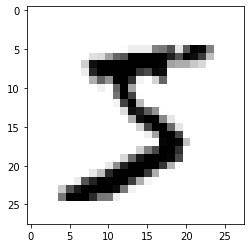

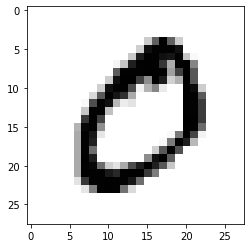

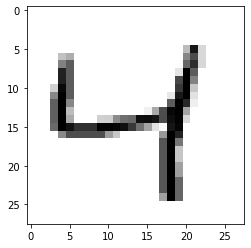

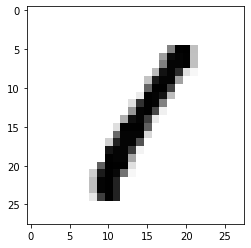

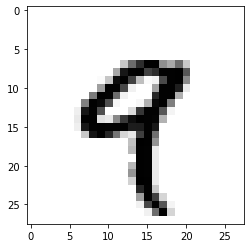

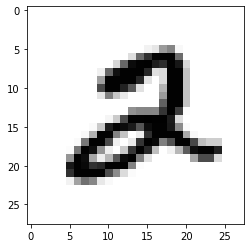

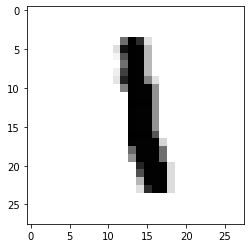

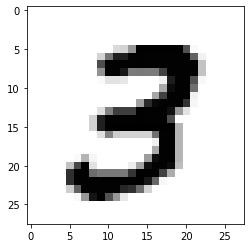

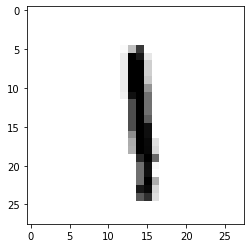

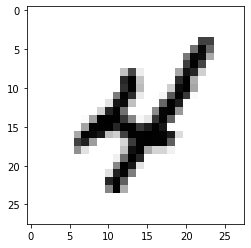

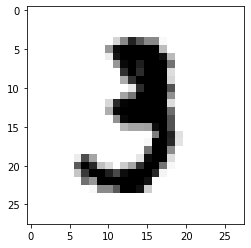

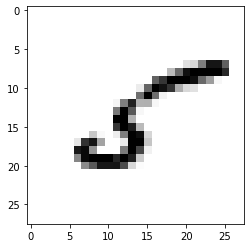

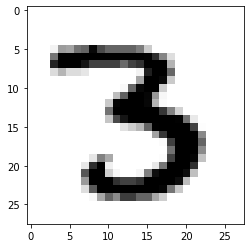

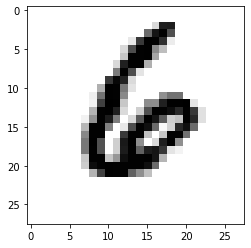

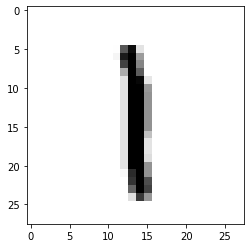

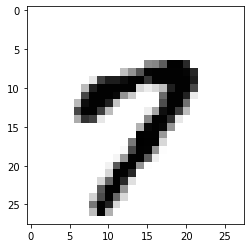

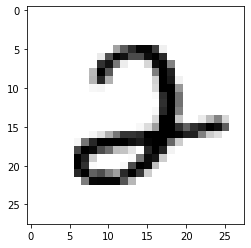

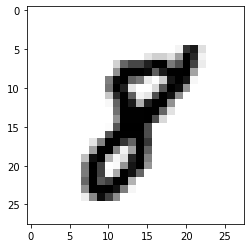

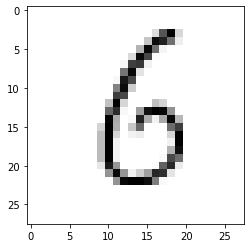

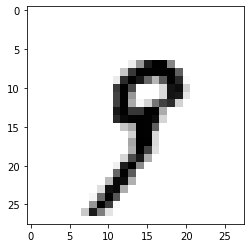

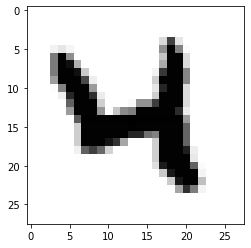

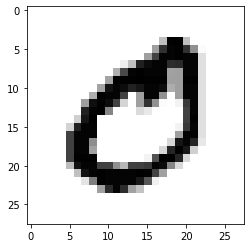

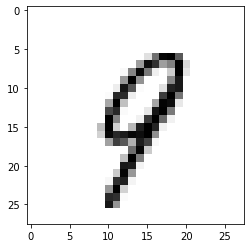

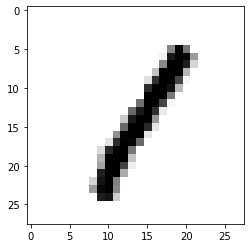

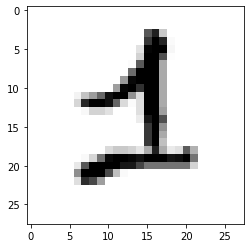

In [ ]:
imagefile = '/content/drive/MyDrive/data/MNIST/raw/train-images-idx3-ubyte'
imageArr = read_image(imagefile,1)
img  = Image.fromarray(imageArr)
#img.show()

for idx in range(25):
  imagearray = idx2numpy.convert_from_file(imagefile)
  plt.imshow(imagearray[idx], cmap=plt.cm.binary)
  plt.show()

### **Visualizing the downloaded test images:**

<_io.BufferedRandom name='/content/drive/MyDrive/data/MNIST/raw/t10k-images-idx3-ubyte'>
Number of Images: 10000
Number of Rows: 28
Number of Columns:28


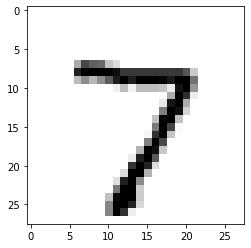

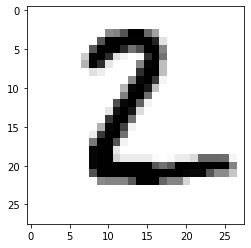

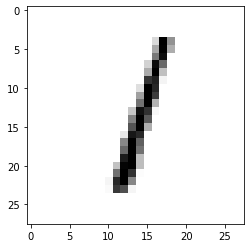

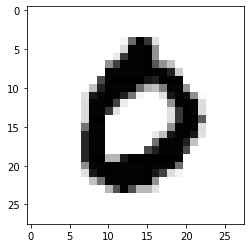

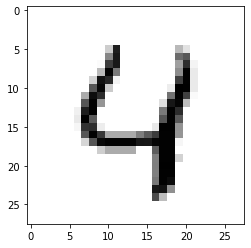

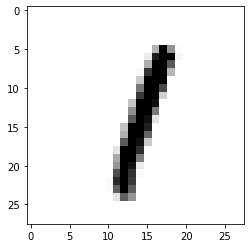

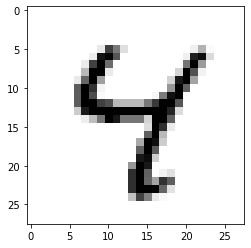

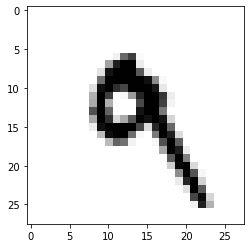

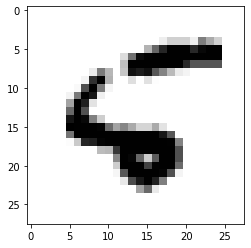

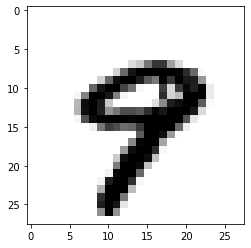

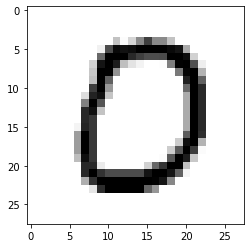

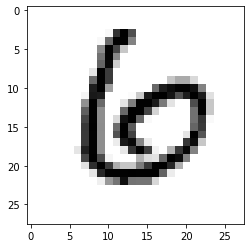

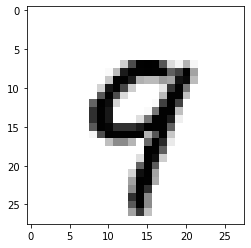

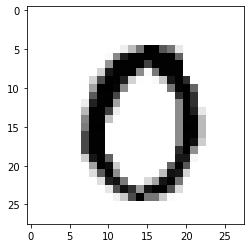

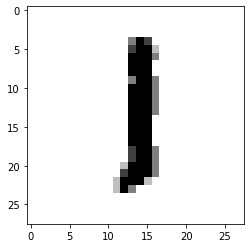

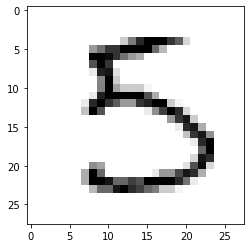

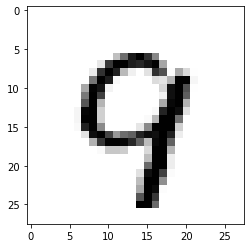

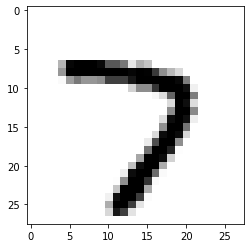

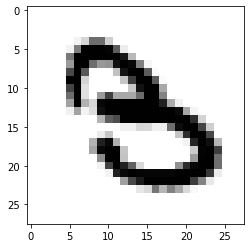

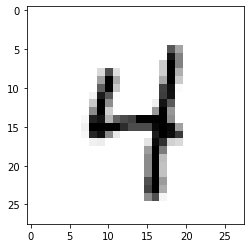

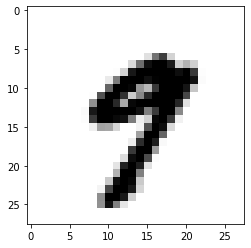

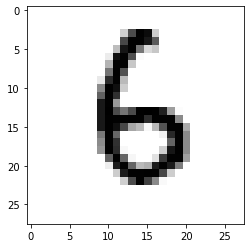

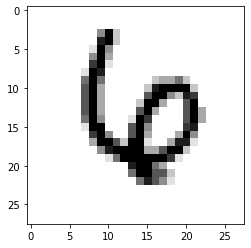

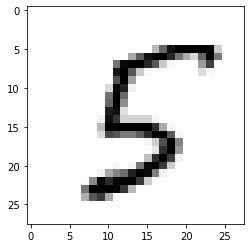

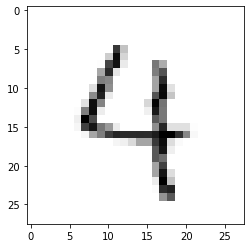

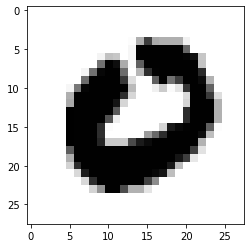

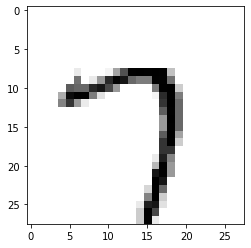

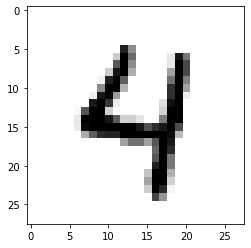

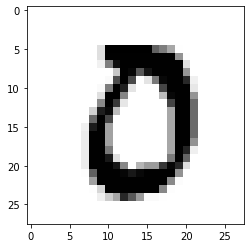

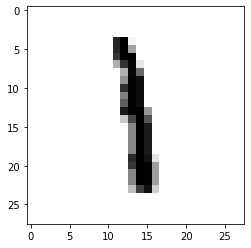

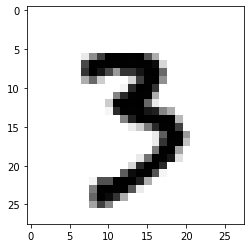

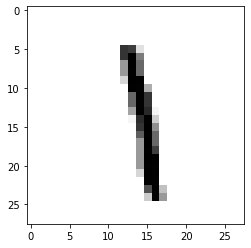

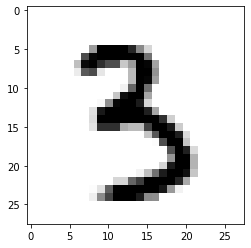

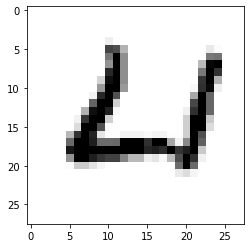

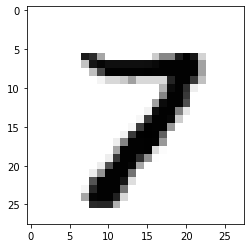

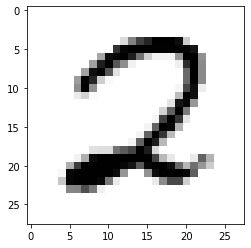

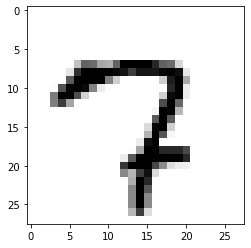

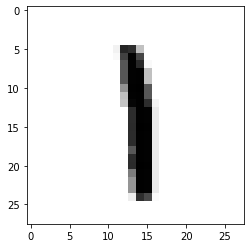

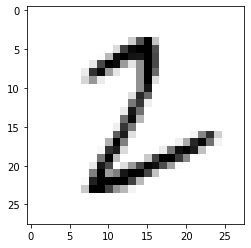

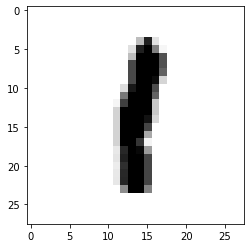

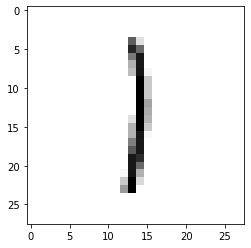

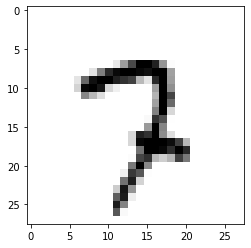

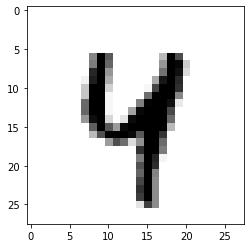

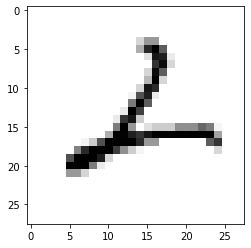

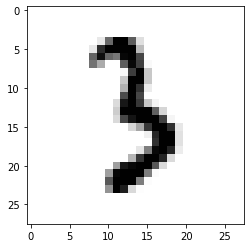

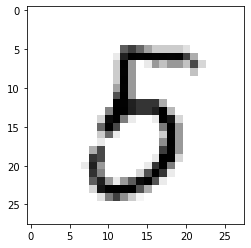

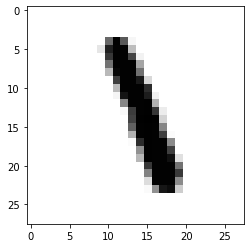

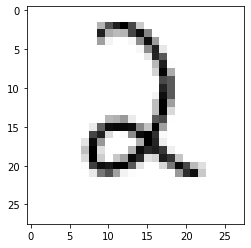

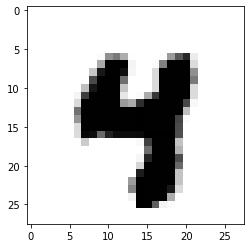

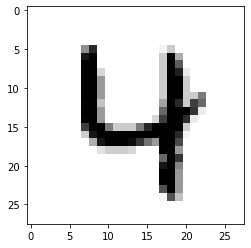

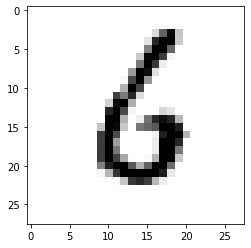

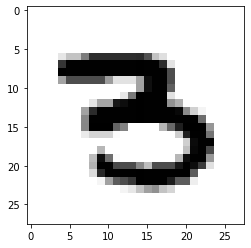

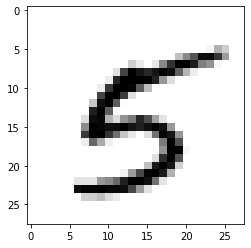

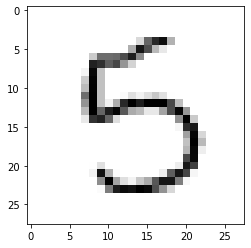

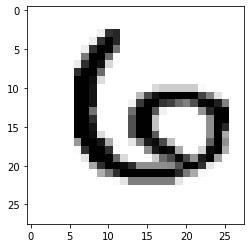

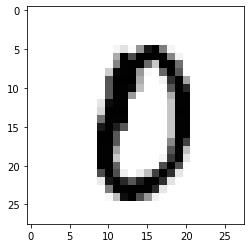

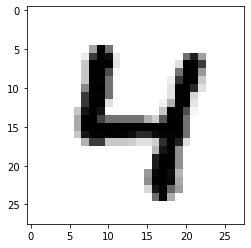

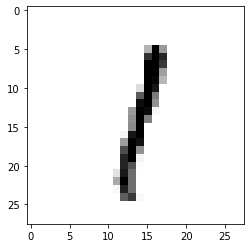

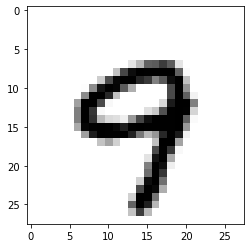

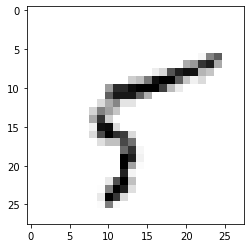

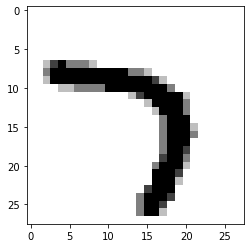

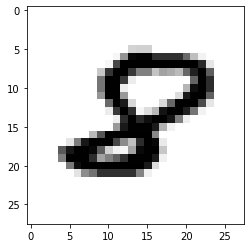

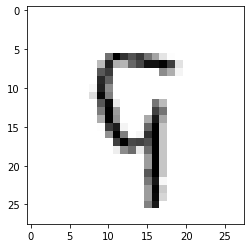

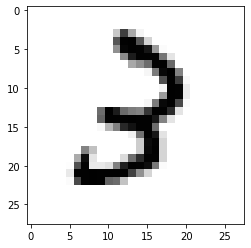

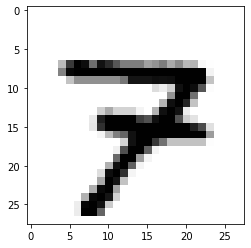

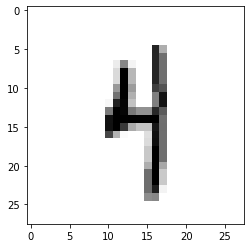

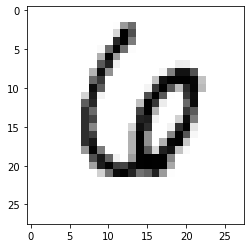

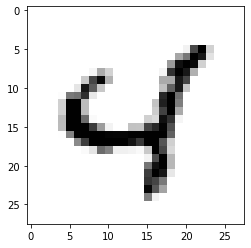

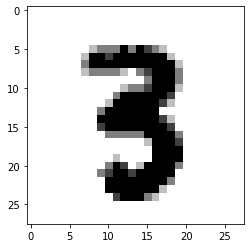

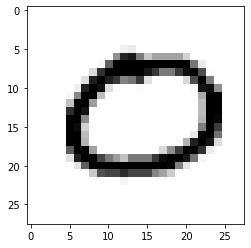

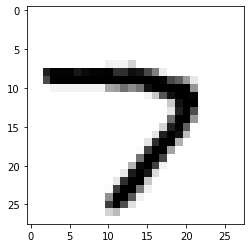

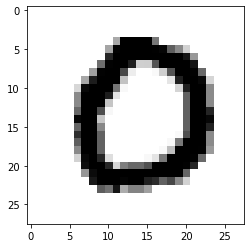

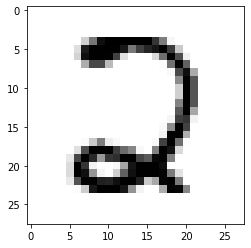

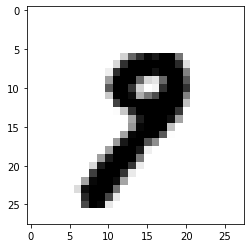

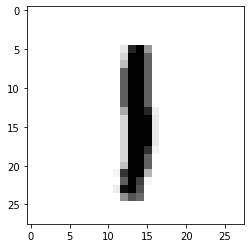

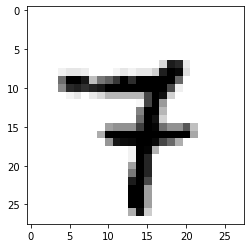

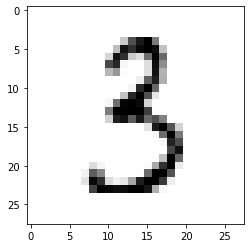

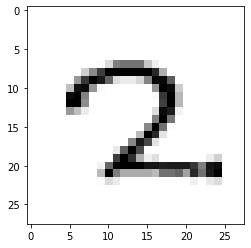

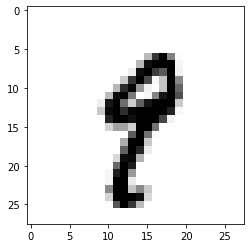

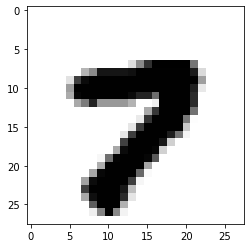

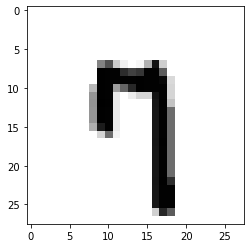

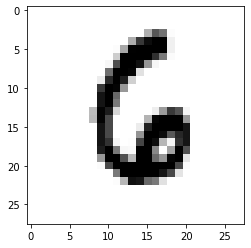

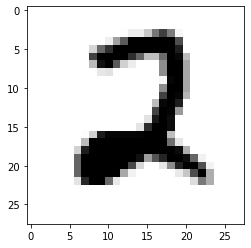

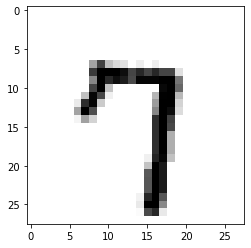

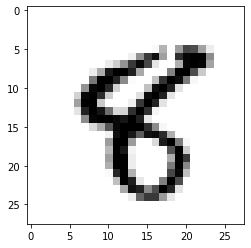

In [ ]:
testImagefile = '/content/drive/MyDrive/data/MNIST/raw/t10k-images-idx3-ubyte'
testImageArr = read_image(testImagefile,1)
img  = Image.fromarray(testImageArr)
#img.show()
# showing the 5 test images
for idx in range(85):
  testImageArr = idx2numpy.convert_from_file(testImagefile)
  plt.imshow(testImageArr[idx], cmap=plt.cm.binary)
  plt.show()

### **Augmenting train data:**

In [ ]:
from data import dataloaders
dataloaders('mnist', 64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(<torch.utils.data.dataloader.DataLoader at 0x7fc856525f40>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc8564b5d90>)

### **View the augmented train data:**

In [ ]:
augmentedTrainDs = torch.load('/content/augmentedTrainDs.pt')
image, label = augmentedTrainDs[0]
print("Shape: ", image.shape, '\nlabel: ', label)


Shape:  torch.Size([1, 28, 28]) 
label:  5


Text(0.5, 1.0, 'Label = 5')

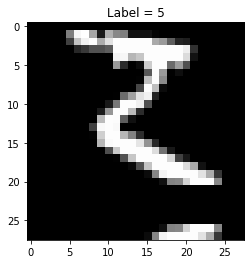

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[2]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  4


Text(0.5, 1.0, 'Label = 4')

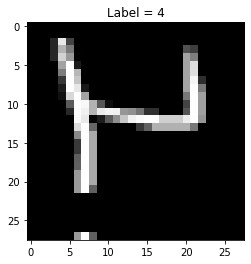

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[21]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  0


Text(0.5, 1.0, 'Label = 0')

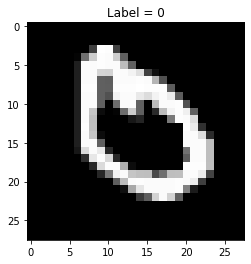

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[24]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  1


Text(0.5, 1.0, 'Label = 1')

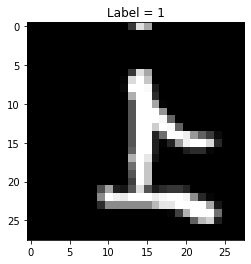

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[17]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  8


Text(0.5, 1.0, 'Label = 8')

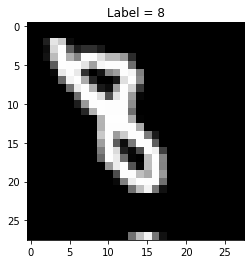

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[4]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  9


Text(0.5, 1.0, 'Label = 9')

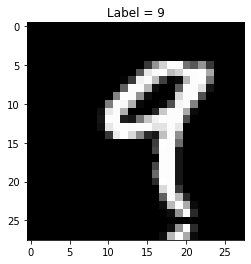

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[5]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  2


Text(0.5, 1.0, 'Label = 2')

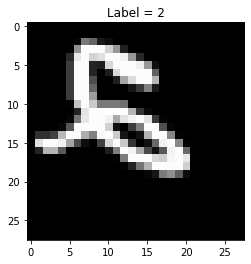

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[7]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  3


Text(0.5, 1.0, 'Label = 3')

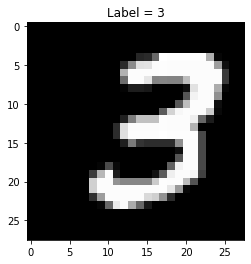

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[13]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  6


Text(0.5, 1.0, 'Label = 6')

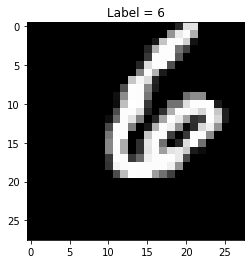

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

In [ ]:
image, label = augmentedTrainDs[15]
print("Shape: ", image.shape, '\nlabel: ', label)

Shape:  torch.Size([1, 28, 28]) 
label:  7


Text(0.5, 1.0, 'Label = 7')

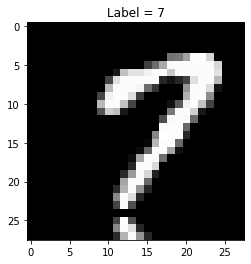

In [ ]:
plt.imshow(image.reshape(28,28), cmap='gray')
plt.title('Label = ' + str(label))

### **Compute centroid class:**

In [ ]:
%%writefile compute_centroids.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python

import numpy as np
from pathlib import Path
import argparse

from torchvision.transforms import ToTensor
from sklearn.cluster import KMeans, MiniBatchKMeans

from data import DATASETS


def download(dataset, datapath):
    train_ds = DATASETS[dataset](
        datapath, train=True, download=True, transform=ToTensor()
    )
    train_x = np.stack([x.numpy() for x, _ in train_ds])
    train_x = train_x.transpose(0, 2, 3, 1)  # put channel dimension last
    return train_x


def find_centroids(train_x, num_clusters=16, batch_size=1024):
    pixels = train_x.reshape(-1, train_x.shape[-1])
    if batch_size:
        kmeans = MiniBatchKMeans(
            n_clusters=num_clusters, random_state=0, batch_size=batch_size
        ).fit(pixels)
    else:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(pixels)
    return kmeans.cluster_centers_


def main(args):
    datapath = Path("/content/drive/MyDrive/data")
    datapath.mkdir(exist_ok=True)

    train_x = download(args.dataset, datapath)
    centroids = find_centroids(train_x, args.num_clusters, args.batch_size)
    np.save(datapath / f"{args.dataset}_centroids.npy", centroids)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset", type=str, choices=DATASETS.keys(), default="mnist")
    parser.add_argument("--num_clusters", default=16, type=int)
    parser.add_argument(
        "--batch_size",
        default=1024,
        type=int,
        help="batch size for mini batch kmeans to quantize images",
    )
    args = parser.parse_args()
    main(args)

Writing compute_centroids.py


In [ ]:
# coumputing the centroid for images with cluster size 16
!python3 compute_centroids.py --dataset mnist --num_clusters=16

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### **Showing the calculated centroid:**

In [ ]:
centroid_array = np.load('/content/drive/MyDrive/data/mnist_centroids.npy')
centroid_array

array([[4.6009950e-02],
       [0.0000000e+00],
       [9.0842378e-01],
       [6.4877909e-01],
       [1.9636802e-01],
       [9.5917130e-01],
       [8.4038848e-01],
       [1.0886785e-01],
       [9.9838632e-01],
       [5.3333485e-01],
       [7.5291753e-01],
       [1.4276293e-04],
       [9.9838412e-01],
       [3.0014792e-01],
       [9.9915224e-01],
       [4.1853124e-01]], dtype=float32)

### **Utility class for miscellaneous uses:** 

In [ ]:
%%writefile utils.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python
import torch


def squared_euclidean_distance(a, b):
    b = torch.transpose(b, 0, 1)
    a2 = torch.sum(torch.square(a), dim=1, keepdims=True)
    b2 = torch.sum(torch.square(b), dim=0, keepdims=True)
    ab = torch.matmul(a, b)
    d = a2 - 2 * ab + b2
    return d


def quantize(x, centroids):
    b, c, h, w = x.shape
    # [B, C, H, W] => [B, H, W, C]
    x = x.permute(0, 2, 3, 1).contiguous()
    x = x.view(-1, c)  # flatten to pixels
    d = squared_euclidean_distance(x, centroids)
    x = torch.argmin(d, 1)
    x = x.view(b, h, w)
    return x


def unquantize(x, centroids):
    return centroids[x]

Writing utils.py


### **Actual GPT2 class:**

In [ ]:
%%writefile gpt2.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python

import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)
        self.ln_2 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )

    def forward(self, x):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        x = self.ln_1(x)
        a, _ = self.attn(x, x, x, attn_mask=attn_mask, need_weights=False)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x


class GPT2(nn.Module):
    def __init__(
        self, embed_dim, num_heads, num_layers, num_positions, num_vocab, num_classes
    ):
        super(GPT2, self).__init__()

        self.embed_dim = embed_dim

        # start of sequence token
        self.sos = torch.nn.Parameter(torch.zeros(embed_dim))
        nn.init.normal_(self.sos)

        self.token_embeddings = nn.Embedding(num_vocab, embed_dim)
        self.position_embeddings = nn.Embedding(num_positions, embed_dim)

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(Block(embed_dim, num_heads))

        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_vocab, bias=False)
        self.clf_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x, classify=False):
        """
        Expect input as shape [sequence len, batch]
        If classify, return classification logits
        """
        length, batch = x.shape

        h = self.token_embeddings(x)

        # prepend sos token
        sos = torch.ones(1, batch, self.embed_dim, device=x.device) * self.sos
        h = torch.cat([sos, h[:-1, :, :]], axis=0)

        # add positional embeddings
        positions = torch.arange(length, device=x.device).unsqueeze(-1)
        h = h + self.position_embeddings(positions).expand_as(h)

        # transformer
        for layer in self.layers:
            h = layer(h)

        h = self.ln_f(h)

        logits = self.head(h)

        if not classify:
            # return logits
            return logits

        h = torch.mean(h, dim=0)  # average pool over sequence
        # return classification logits and generative logits
        return self.clf_head(h), logits

Writing gpt2.py


### **Image GPT implementation:**

In [ ]:
%%writefile image_gpt.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR
import pytorch_lightning as pl
import numpy as np
import math
from argparse import ArgumentParser

from gpt2 import GPT2
from utils import quantize


def _to_sequence(x):
    """shape batch of images for input into GPT2 model"""
    x = x.view(x.shape[0], -1)  # flatten images into sequences
    x = x.transpose(0, 1).contiguous()  # to shape [seq len, batch]
    return x


class ImageGPT(pl.LightningModule):
    def __init__(
        self,
        centroids,
        embed_dim=16,
        num_heads=2,
        num_layers=8,
        num_pixels=28,
        num_vocab=16,
        num_classes=10,
        classify=False,
        learning_rate=3e-3,
        steps=10_000,
        warmup_steps=500,
        **kwargs,
    ):
        super(ImageGPT, self).__init__()
        self.save_hyperparameters()
        self.gpt = GPT2(
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            num_positions=num_pixels * num_pixels,
            num_vocab=num_vocab,
            num_classes=num_classes,
        )

        self.centroids = nn.Parameter(
            torch.from_numpy(np.load('/content/drive/MyDrive/data/mnist_centroids.npy')), requires_grad=False
        )
        self.criterion = nn.CrossEntropyLoss()
        self.classify = classify
        self.learning_rate = learning_rate
        self.steps = steps
        self.warmup_steps = warmup_steps

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--embed_dim", type=int, default=16)
        parser.add_argument("--num_heads", type=int, default=2)
        parser.add_argument("--num_layers", type=int, default=8)
        parser.add_argument("--num_pixels", type=int, default=28)
        parser.add_argument("--num_vocab", type=int, default=16)
        parser.add_argument("--num_classes", type=int, default=10)
        parser.add_argument("--classify", action="store_true", default=False)
        parser.add_argument("--batch_size", type=int, default=64)
        parser.add_argument("--learning_rate", type=float, default=3e-3)
        parser.add_argument("--steps", type=int, default=25_000)
        return parser

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.gpt.parameters(), lr=self.learning_rate)

        # no learning rate schedule for fine-tuning
        if self.classify:
            return optimizer

        scheduler = {
            "scheduler": LambdaLR(
                optimizer, learning_rate_schedule(self.warmup_steps, self.steps)
            ),
            "interval": "step",
        }
        return [optimizer], [scheduler]

    def forward(self, x):
        return self.gpt(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        x = quantize(x, self.centroids)
        x = _to_sequence(x)

        if self.classify:
            clf_logits, logits = self.gpt(x, classify=True)
            clf_loss = self.criterion(clf_logits, y)
            gen_loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))
            # joint loss for classification
            loss = clf_loss + gen_loss
        else:
            logits = self.gpt(x)
            loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch

        x = quantize(x, self.centroids)
        x = _to_sequence(x)

        if self.classify or self.hparams.classify:
            clf_logits, logits = self.gpt(x, classify=True)
            clf_loss = self.criterion(clf_logits, y)
            gen_loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))
            # joint loss for classification
            loss = clf_loss + gen_loss
            _, preds = torch.max(clf_logits, 1)
            correct = preds == y
            return {"val_loss": loss, "correct": correct}
        else:
            logits = self.gpt(x)
            loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))
            return {"val_loss": loss}

    def validation_epoch_end(self, outs):
        avg_loss = torch.stack([x["val_loss"] for x in outs]).mean()
        logs = {"val_loss": avg_loss}
        if self.classify or self.hparams.classify:
            correct = torch.cat([x["correct"] for x in outs])
            logs["val_acc"] = correct.sum().float() / correct.shape[0]
        return {"val_loss": avg_loss, "log": logs}

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def test_epoch_end(self, outs):
        result = self.validation_epoch_end(outs)

        # replace valid stats with test stats becuase we are reusing function
        result["log"]["test_loss"] = result["log"].pop("val_loss")
        result["test_loss"] = result.pop("val_loss")
        if self.hparams.classify:
            result["log"]["test_acc"] = result["log"].pop("val_acc")
        return result


def learning_rate_schedule(warmup_steps, total_steps):
    """Linear warmup for warmup_steps, with cosine annealing to 0 at total_steps"""

    def learning_rate_fn(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        else:
            progress = float(step - warmup_steps) / float(
                max(1, total_steps - warmup_steps)
            )
            return 0.5 * (1.0 + math.cos(math.pi * progress))

    return learning_rate_fn

Writing image_gpt.py


### **Train and Test the model:**

In [ ]:
%%writefile run.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
import numpy as np
import argparse
import yaml


from image_gpt import ImageGPT
from data import dataloaders


def train(args):

    with open(args.config, "rb") as f:
        config = yaml.safe_load(f)

    # experiment name
    name = f"{config['name']}_{args.dataset}"

    if args.pretrained is not None:
        model = ImageGPT.load_from_checkpoint(args.pretrained)
        # potentially modify model for finetuning
        model.learning_rate = config["learning_rate"]
        model.classify = config["classify"]
    else:
        model = ImageGPT(centroids=args.centroids, **config)

    train_dl, valid_dl, test_dl = dataloaders(args.dataset, config["batch_size"])
    logger = pl_loggers.TensorBoardLogger("logs", name=name)

    if config["classify"]:
        # classification
        # stop early for best validation accuracy for finetuning
        early_stopping = pl.callbacks.EarlyStopping(
            monitor="val_acc", patience=3, mode="max"
        )
        checkpoint = pl.callbacks.ModelCheckpoint(monitor="val_acc")
        trainer = pl.Trainer(
            max_steps=config["steps"],
            gpus=config["gpus"],
            accumulate_grad_batches=config.get("accumulate_grad_batches", 1),
            precision=config.get("precision", 32),
            early_stop_callback=early_stopping,
            checkpoint_callback=checkpoint,
            logger=logger,
        )

    else:
        # pretraining
        #checkpoint = pl.callbacks.ModelCheckpoint(monitor="loss")
        #max_epochs=5
        checkpoint = pl.callbacks.ModelCheckpoint(monitor=None)
        trainer = pl.Trainer(
            max_steps=config["steps"],
            gpus=config["gpus"],
            precision=config["precision"],
            accumulate_grad_batches=config["accumulate_grad_batches"],
            callbacks=[checkpoint],
            logger=logger,
        )

    trainer.fit(model, train_dl, valid_dl)
    #torch.save(model, 'mnist_generated.pt')


def test(args):
    with open(args.config, "rb") as f:
        config = yaml.safe_load(f)
    trainer = pl.Trainer(gpus=config["gpus"])
    _, _, test_dl = dataloaders(args.dataset, config["batch_size"])
    model = ImageGPT.load_from_checkpoint(args.checkpoint)
    if config["classify"]:
        model.hparams.classify = True
    trainer.test(model, test_dataloaders=test_dl)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument("--dataset", default="mnist")

    subparsers = parser.add_subparsers()
    parser_train = subparsers.add_parser("train")
    parser_train.add_argument("--pretrained", type=str, default=None)
    parser_train.add_argument("config", type=str)
    parser_train.set_defaults(func=train)

    parser_test = subparsers.add_parser("test")
    parser_test.add_argument("checkpoint", type=str)
    parser_test.add_argument("config", type=str)
    parser_test.set_defaults(func=test)

    args = parser.parse_args()
    args.centroids = f"data/{args.dataset}_centroids.npy"

    args.func(args)

Writing run.py


In [ ]:
# training the model with MNIST data with small configuration
!python3 run.py --dataset mnist train xxs_gen.yml

100% 9912422/9912422 [00:00<00:00, 83936565.12it/s]
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

100% 28881/28881 [00:00<00:00, 22362136.57it/s]
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

100% 1648877/1648877 [00:00<00:00, 22220159.74it/s]
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

100% 4542/4542 [00:00<00:00, 22787713.84it/s]
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/pyt

### **Visualizing the loss:**

In [ ]:
with open('/content/drive/MyDrive/iGPT_s_loss.json', 'r') as f:
    data = json.load(f)

<ipython-input-4-16b28ca6c6cc>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


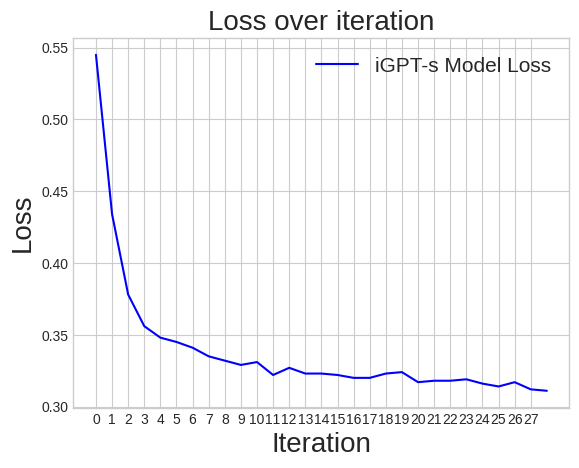

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (10,14)
plt.plot(data['iterations'], data['loss'], label='iGPT-s Model Loss',c='blue')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Loss over iteration", fontsize= 20)
plt.show()

In [ ]:
with open('/content/drive/MyDrive/iGPT_m_loss.json', 'r') as f:
    data = json.load(f)

<ipython-input-4-1aa7d23aab4b>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


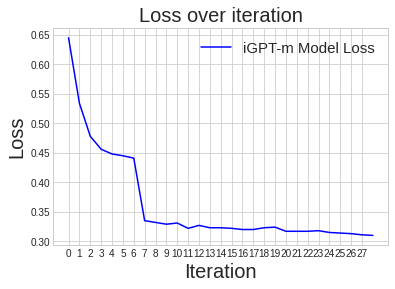

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (10,14)
plt.plot(data['iterations'], data['loss'], label='iGPT-m Model Loss',c='blue')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Loss over iteration", fontsize= 20)
plt.show()

In [ ]:
with open('/content/drive/MyDrive/iGPT_l_loss.json', 'r') as f:
    data = json.load(f)

<ipython-input-4-aa116cb4b2c9>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


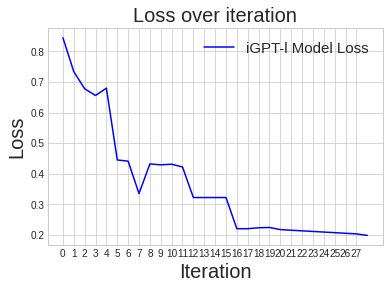

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (10,14)
plt.plot(data['iterations'], data['loss'], label='iGPT-l Model Loss',c='blue')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Loss over iteration", fontsize= 20)
plt.show()

In [ ]:
with open('/content/drive/MyDrive/iGPT_all_loss.json', 'r') as f:
    data = json.load(f)

<ipython-input-7-e63bcfd7572e>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Text(0.5, 1.0, 'Loss vs iteration for iGPT Models')

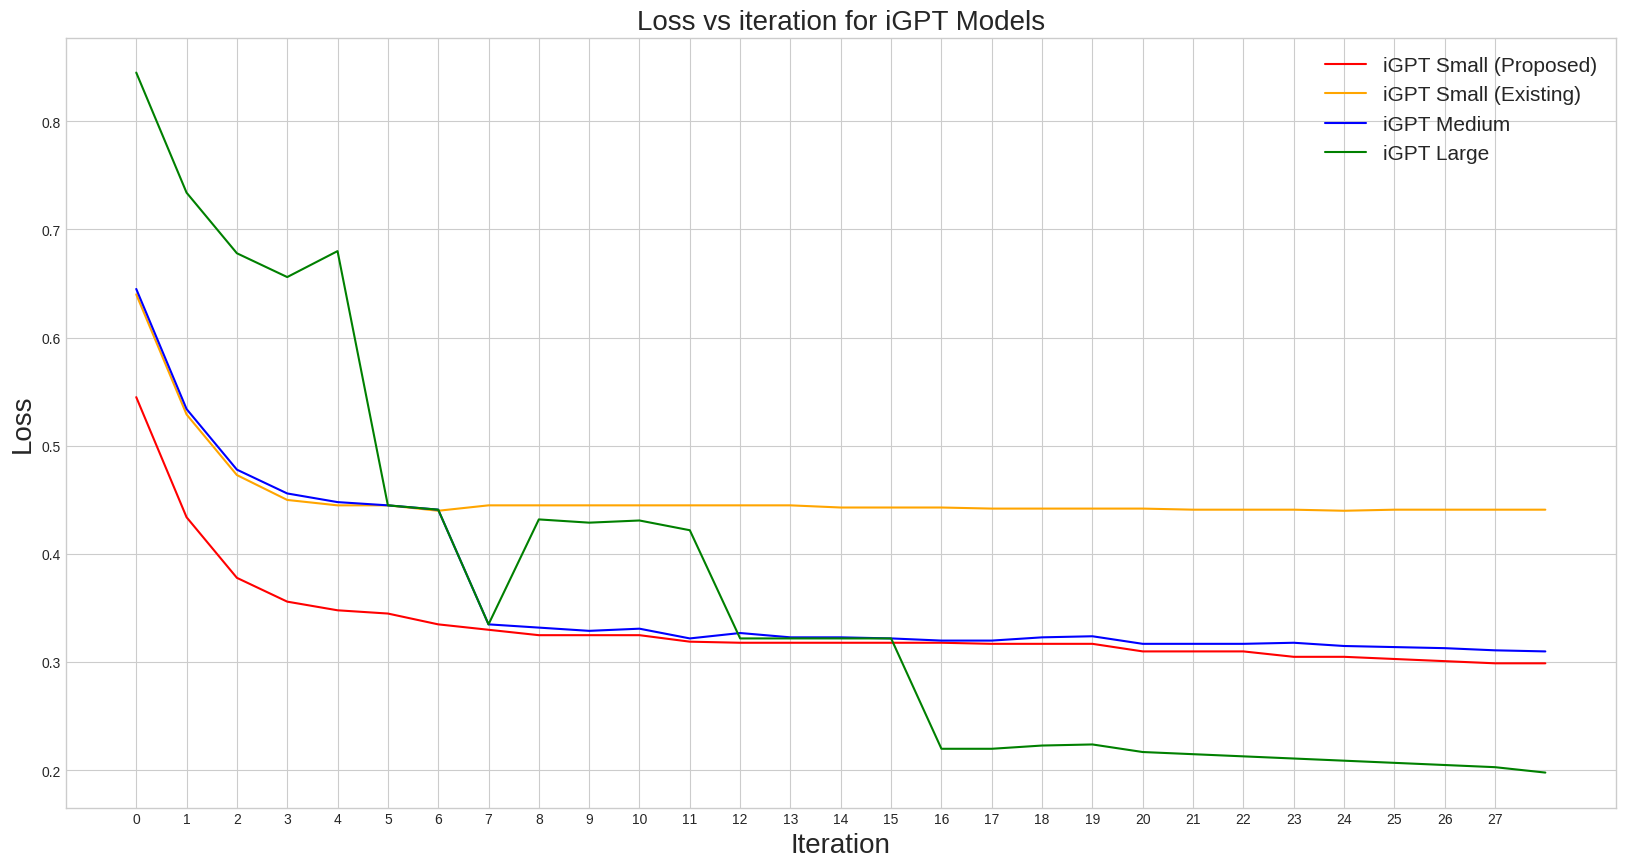

In [ ]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['loss_small'],  label='iGPT Small (Proposed)',c='red')
plt.plot(data['iterations'], data['loss_small_original'],  label='iGPT Small (Existing)',c='orange')
plt.plot(data['iterations'], data['loss_medium'], label='iGPT Medium',c='blue')
plt.plot(data['iterations'], data['loss_large'], label='iGPT Large', c='green')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Loss vs iteration for iGPT Models", fontsize= 20)

**Validate image completion against saved pre-trained model:**

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import argparse
from tqdm import tqdm
from PIL import Image

from image_gpt import ImageGPT
from torch.utils.data import DataLoader
from utils import quantize, unquantize
from data import dataloaders

import matplotlib.pyplot as plt


def sample(model, context, length, num_samples=1, temperature=1.0):

    output = context.unsqueeze(-1).repeat_interleave(
        num_samples, dim=-1
    )  # add batch so shape [seq len, batch]

    pad = torch.zeros(1, num_samples, dtype=torch.long).cuda()  # to pad prev output
    with torch.no_grad():
        for _ in tqdm(range(length), leave=False):
            logits = model(torch.cat((output, pad), dim=0))
            logits = logits[-1, :, :] / temperature
            probs = F.softmax(logits, dim=-1)
            pred = torch.multinomial(probs, num_samples=1).transpose(1, 0)
            output = torch.cat((output, pred), dim=0)
    return output


def make_figure(rows, centroids):
    figure = np.stack(rows, axis=0)
    print(figure.shape)
    rows, cols, h, w = figure.shape
    figure = unquantize(figure.swapaxes(1, 2).reshape(h * rows, w * cols), centroids)
    figure = (figure * 256).astype(np.uint8)
    return Image.fromarray(np.squeeze(figure))



In [ ]:
num_examples = 5
num_samples = 5


In [ ]:
model = ImageGPT.load_from_checkpoint('/content/mnist_gen.ckpt').gpt.eval().cuda()
centroids = np.load(f"//content/drive/MyDrive/data/mnist_centroids.npy")
train_dl, valid_dl, test_dl = dataloaders('mnist', 1)
dl = iter(DataLoader(valid_dl.dataset, shuffle=True))
# rows for figure
rows = []

for example in tqdm(range(num_examples)):
        img, _ = next(dl)
        h, w = img.shape[-2:]

        img = quantize(img, torch.from_numpy(centroids)).numpy()[0]
        seq = img.reshape(-1)

        # first half of image is context
        context = seq[: int(len(seq) / 2)]
        context_img = np.pad(context, (0, int(len(seq) / 2))).reshape(h, w)
        context = torch.from_numpy(context).cuda()

        # predict second half of image
        preds = (
            sample(model, context, int(len(seq) / 2), num_samples=num_samples)
            .cpu()
            .numpy()
            .transpose()
        )

        preds = preds.reshape(-1, h, w)

        # combine context, preds, and truth for figure
        rows.append(
            np.concatenate([context_img[None, ...], preds, img[None, ...]], axis=0)
        )


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v0.9.0 to v1.9.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file mnist_gen.ckpt`
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Ple

**Generating some sample figure:**

(5, 7, 28, 28)


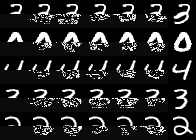

In [ ]:
figure = make_figure(rows, centroids)
figure.save("sampling_figure.png")
figure.show()

## **Graph generation module:**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.5 MB/s eta 0:00:00


In [ ]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

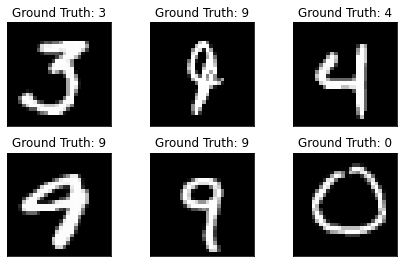

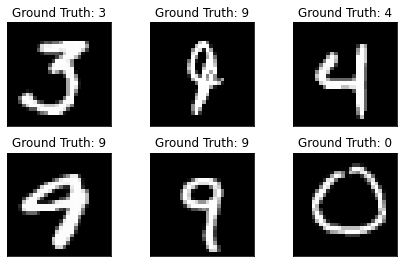

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/drive/MyDrive/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/drive/MyDrive/results/optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-29-fe54d3ae7723>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140686
Train Epoch: 1 [12160/6

## **Evaluating the Model's Performance**

In [ ]:
with torch.no_grad():
  output = network(example_data)

<ipython-input-29-fe54d3ae7723>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


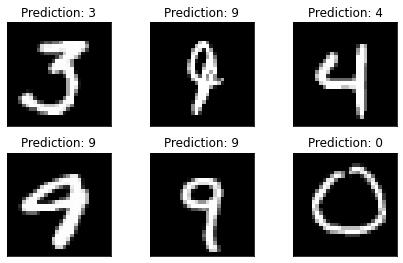

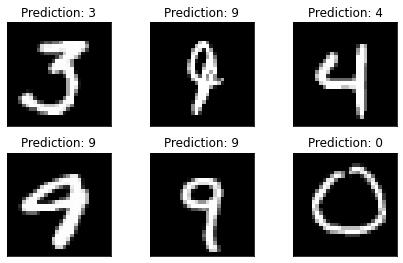

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
train = pd.read_csv("/content/drive/MyDrive/train.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 
X_train = X_train / 255.0
test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)
sns.set(style='white', context='notebook', palette='deep')

In [ ]:
train.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

<Axes: >

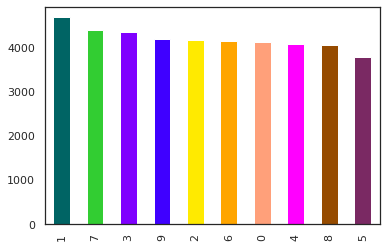

In [ ]:
train.label.value_counts().plot.bar(color=[(0,100/255,100/255),(50/255, 205/255, 50/255),(127/255,0/255,255/255), (63/255,0/255,255/255),   (1,234/255,0), (1,165/255,0), (1,160/255, 122/255), (1,0,1),(150/255, 75/255, 0),  (122/255, 41/255, 99/255) ])

In [ ]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
#g = plt.imshow(X_train[0][:,:,0])

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 29 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/29


<ipython-input-48-00f8d670f626>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


439/439 - 19s - loss: 0.4100 - accuracy: 0.8693 - val_loss: 0.0959 - val_accuracy: 0.9726 - lr: 0.0010 - 19s/epoch - 43ms/step
Epoch 2/29


439/439 - 10s - loss: 0.1265 - accuracy: 0.9625 - val_loss: 0.0437 - val_accuracy: 0.9867 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 3/29


439/439 - 11s - loss: 0.0910 - accuracy: 0.9726 - val_loss: 0.0362 - val_accuracy: 0.9881 - lr: 0.0010 - 11s/epoch - 24ms/step
Epoch 4/29


439/439 - 10s - loss: 0.0801 - accuracy: 0.9767 - val_loss: 0.0321 - val_accuracy: 0.9921 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 5/29


439/439 - 10s - loss: 0.0690 - accuracy: 0.9803 - val_loss: 0.0294 - val_accuracy: 0.9921 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 6/29


439/439 - 10s - loss: 0.0674 - accuracy: 0.9805 - val_loss: 0.0252 - val_accuracy: 0.9919 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 7/29


439/439 - 10s - loss: 0.0646 - accuracy: 0.9814 - val_loss: 0.0245 - val_accuracy: 0.9926 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 8/29


439/439 - 10s - loss: 0.0615 - accuracy: 0.9821 - val_loss: 0.0319 - val_accuracy: 0.9912 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 9/29


439/439 - 10s - loss: 0.0578 - accuracy: 0.9829 - val_loss: 0.0266 - val_accuracy: 0.9924 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 10/29


439/439 - 10s - loss: 0.0618 - accuracy: 0.9829 - val_loss: 0.0256 - val_accuracy: 0.9926 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 11/29


439/439 - 10s - loss: 0.0572 - accuracy: 0.9844 - val_loss: 0.0285 - val_accuracy: 0.9921 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 12/29


439/439 - 10s - loss: 0.0668 - accuracy: 0.9832 - val_loss: 0.0457 - val_accuracy: 0.9895 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 13/29


439/439 - 10s - loss: 0.0599 - accuracy: 0.9833 - val_loss: 0.0230 - val_accuracy: 0.9929 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 14/29


439/439 - 10s - loss: 0.0595 - accuracy: 0.9838 - val_loss: 0.0263 - val_accuracy: 0.9929 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 15/29


439/439 - 10s - loss: 0.0633 - accuracy: 0.9833 - val_loss: 0.0331 - val_accuracy: 0.9900 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 16/29


439/439 - 11s - loss: 0.0657 - accuracy: 0.9835 - val_loss: 0.0291 - val_accuracy: 0.9919 - lr: 0.0010 - 11s/epoch - 24ms/step
Epoch 17/29


439/439 - 11s - loss: 0.0654 - accuracy: 0.9828 - val_loss: 0.0328 - val_accuracy: 0.9907 - lr: 0.0010 - 11s/epoch - 26ms/step
Epoch 18/29


439/439 - 11s - loss: 0.0656 - accuracy: 0.9832 - val_loss: 0.0585 - val_accuracy: 0.9895 - lr: 0.0010 - 11s/epoch - 24ms/step
Epoch 19/29


439/439 - 11s - loss: 0.0669 - accuracy: 0.9827 - val_loss: 0.0277 - val_accuracy: 0.9931 - lr: 0.0010 - 11s/epoch - 25ms/step
Epoch 20/29


439/439 - 11s - loss: 0.0638 - accuracy: 0.9834 - val_loss: 0.0282 - val_accuracy: 0.9910 - lr: 0.0010 - 11s/epoch - 24ms/step
Epoch 21/29


439/439 - 10s - loss: 0.0650 - accuracy: 0.9830 - val_loss: 0.0278 - val_accuracy: 0.9931 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 22/29


439/439 - 10s - loss: 0.0677 - accuracy: 0.9826 - val_loss: 0.0499 - val_accuracy: 0.9907 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 23/29


439/439 - 10s - loss: 0.0708 - accuracy: 0.9812 - val_loss: 0.0284 - val_accuracy: 0.9907 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 24/29


439/439 - 11s - loss: 0.0680 - accuracy: 0.9830 - val_loss: 0.0405 - val_accuracy: 0.9905 - lr: 0.0010 - 11s/epoch - 24ms/step
Epoch 25/29


439/439 - 10s - loss: 0.0728 - accuracy: 0.9822 - val_loss: 0.0726 - val_accuracy: 0.9888 - lr: 0.0010 - 10s/epoch - 23ms/step
Epoch 26/29


439/439 - 11s - loss: 0.0729 - accuracy: 0.9819 - val_loss: 0.0314 - val_accuracy: 0.9926 - lr: 0.0010 - 11s/epoch - 24ms/step
Epoch 27/29


439/439 - 10s - loss: 0.0757 - accuracy: 0.9817 - val_loss: 0.0564 - val_accuracy: 0.9886 - lr: 0.0010 - 10s/epoch - 24ms/step
Epoch 28/29


439/439 - 11s - loss: 0.0735 - accuracy: 0.9820 - val_loss: 0.0556 - val_accuracy: 0.9881 - lr: 0.0010 - 11s/epoch - 24ms/step
Epoch 29/29


439/439 - 10s - loss: 0.0735 - accuracy: 0.9822 - val_loss: 0.0283 - val_accuracy: 0.9926 - lr: 0.0010 - 10s/epoch - 23ms/step


In [81]:
with open('/content/drive/MyDrive/iGPT_l_class_loss.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification Loss vs iteration for iGPT Large Models ')

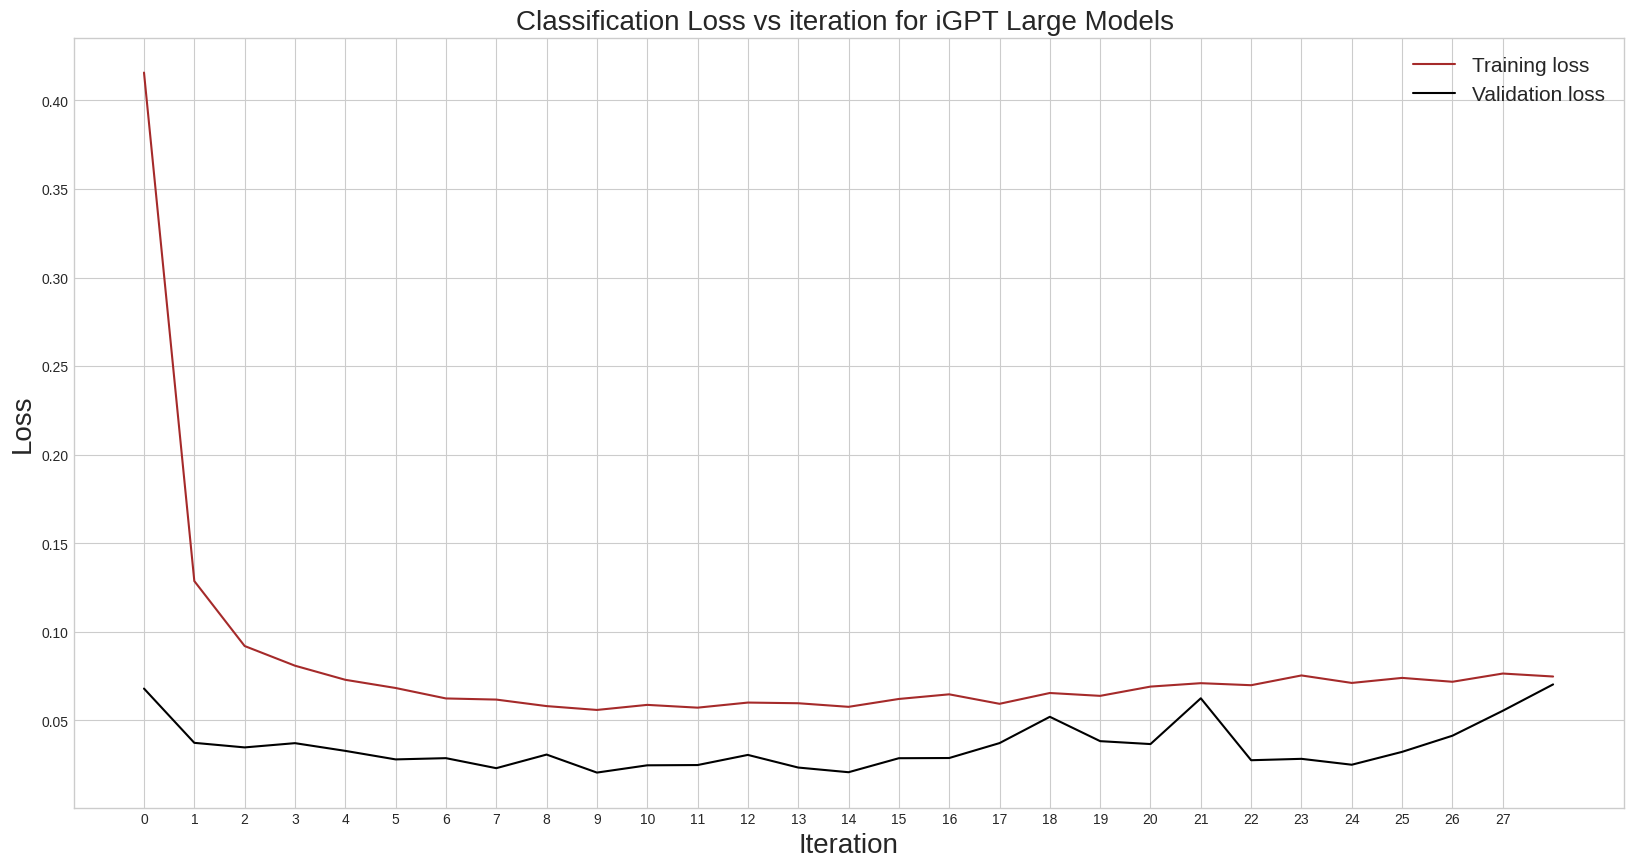

In [82]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_loss'],  label='Training loss',c='brown')
plt.plot(data['iterations'], data['val_loss']   , label='Validation loss',c='black')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification Loss vs iteration for iGPT Large Models ", fontsize= 20)

In [83]:
with open('/content/drive/MyDrive/iGPT_l_class_acc.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification Accuracy vs iteration for iGPT Large Models ')

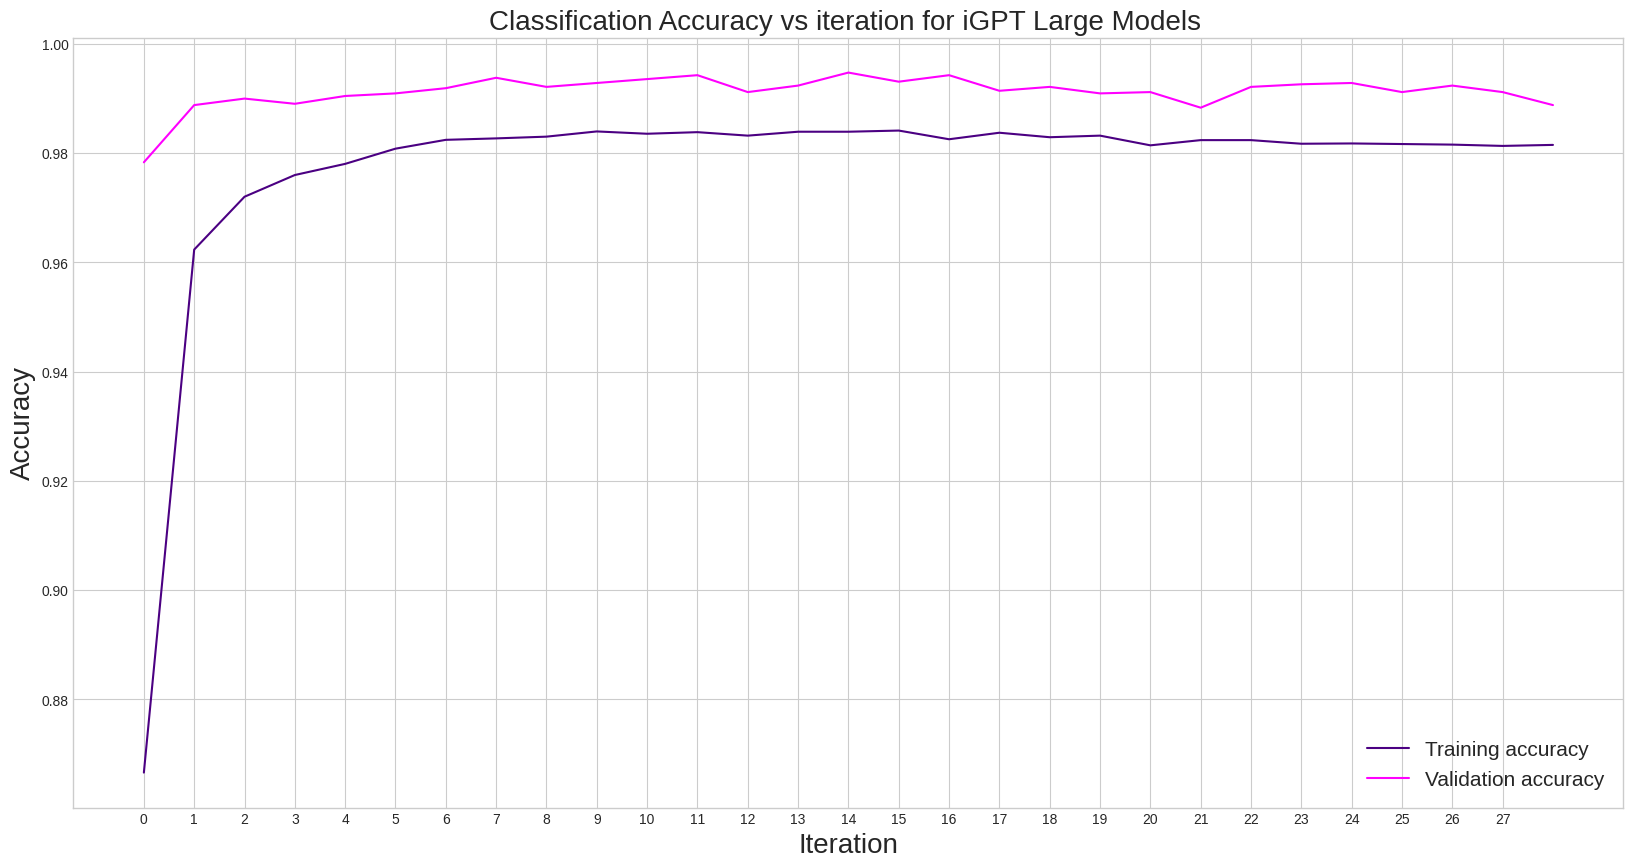

In [84]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_acc'],  label='Training accuracy',c='indigo')
plt.plot(data['iterations'], data['val_acc']   , label='Validation accuracy',c='magenta')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Accuracy", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification Accuracy vs iteration for iGPT Large Models ", fontsize= 20)

In [85]:
with open('/content/drive/MyDrive/iGPT_m_class_loss.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification Loss vs iteration for iGPT Medium Models ')

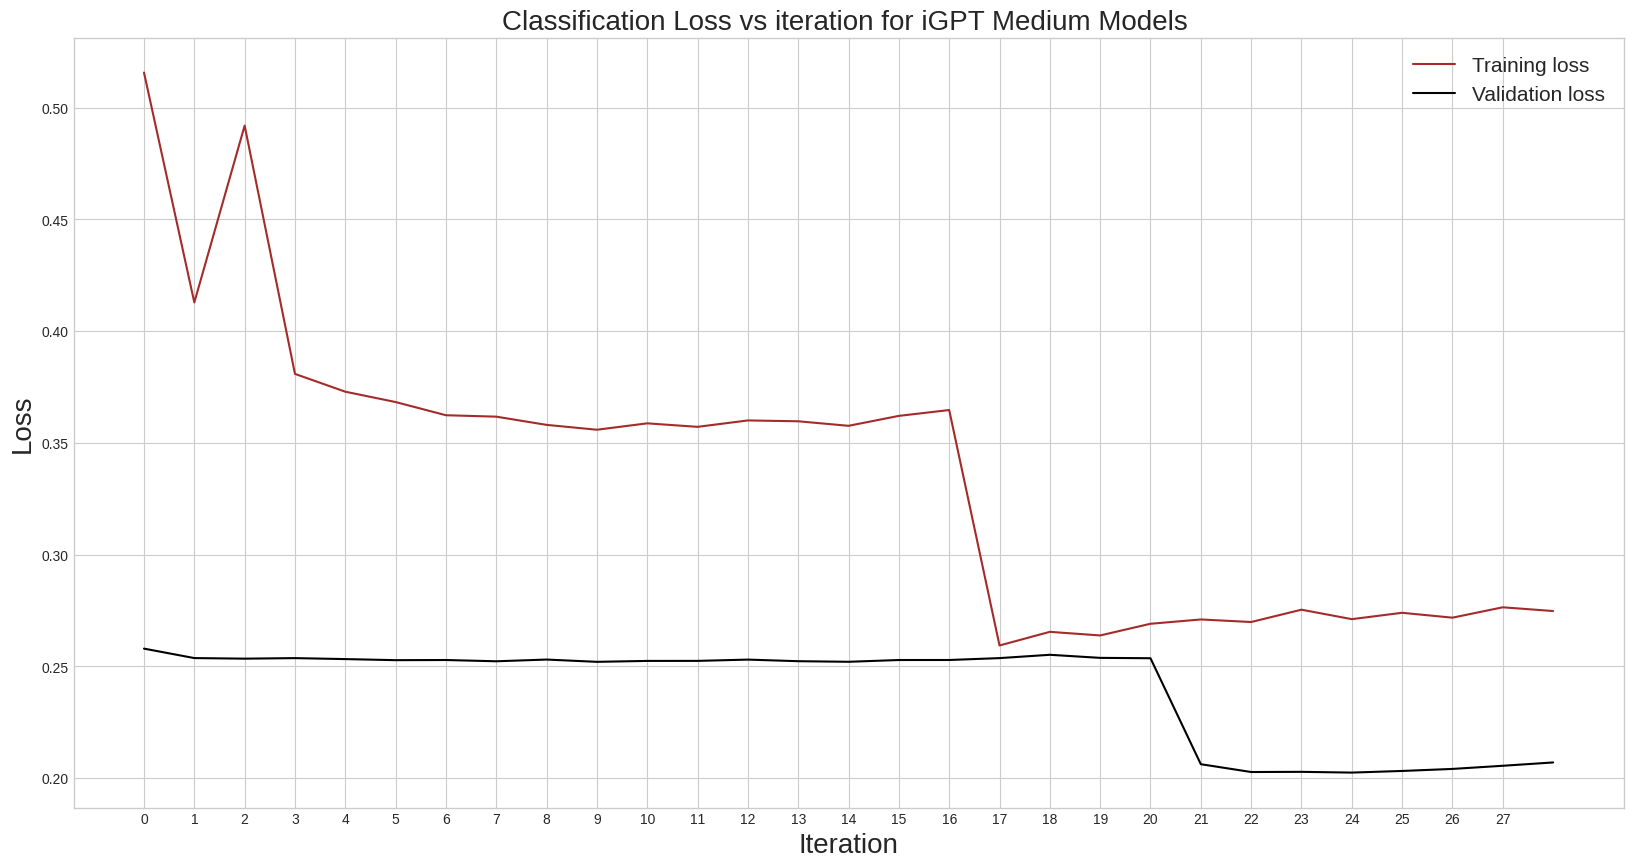

In [86]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_loss'],  label='Training loss',c='brown')
plt.plot(data['iterations'], data['val_loss']   , label='Validation loss',c='black')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification Loss vs iteration for iGPT Medium Models ", fontsize= 20)

In [87]:
with open('/content/drive/MyDrive/iGPT_m_class_acc .json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification Accuracy vs iteration for iGPT Medium Models ')

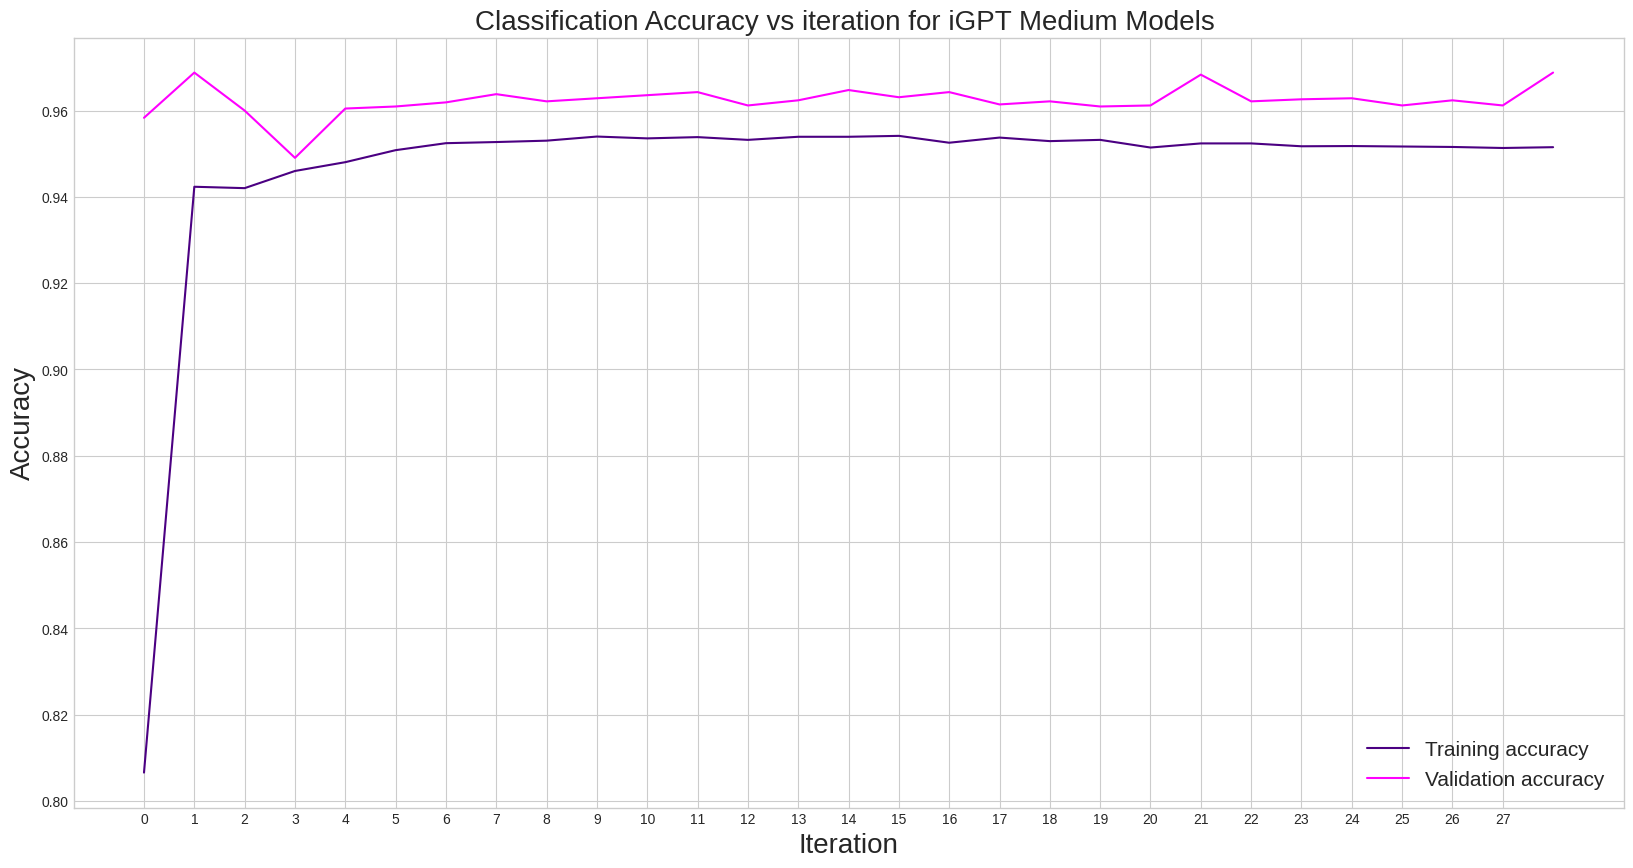

In [88]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_acc'],  label='Training accuracy',c='indigo')
plt.plot(data['iterations'], data['val_acc']   , label='Validation accuracy',c='magenta')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Accuracy", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification Accuracy vs iteration for iGPT Medium Models ", fontsize= 20)

In [67]:
with open('/content/drive/MyDrive/iGPT_s_class_loss.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification Loss vs iteration for iGPT Small Models (Existing)')

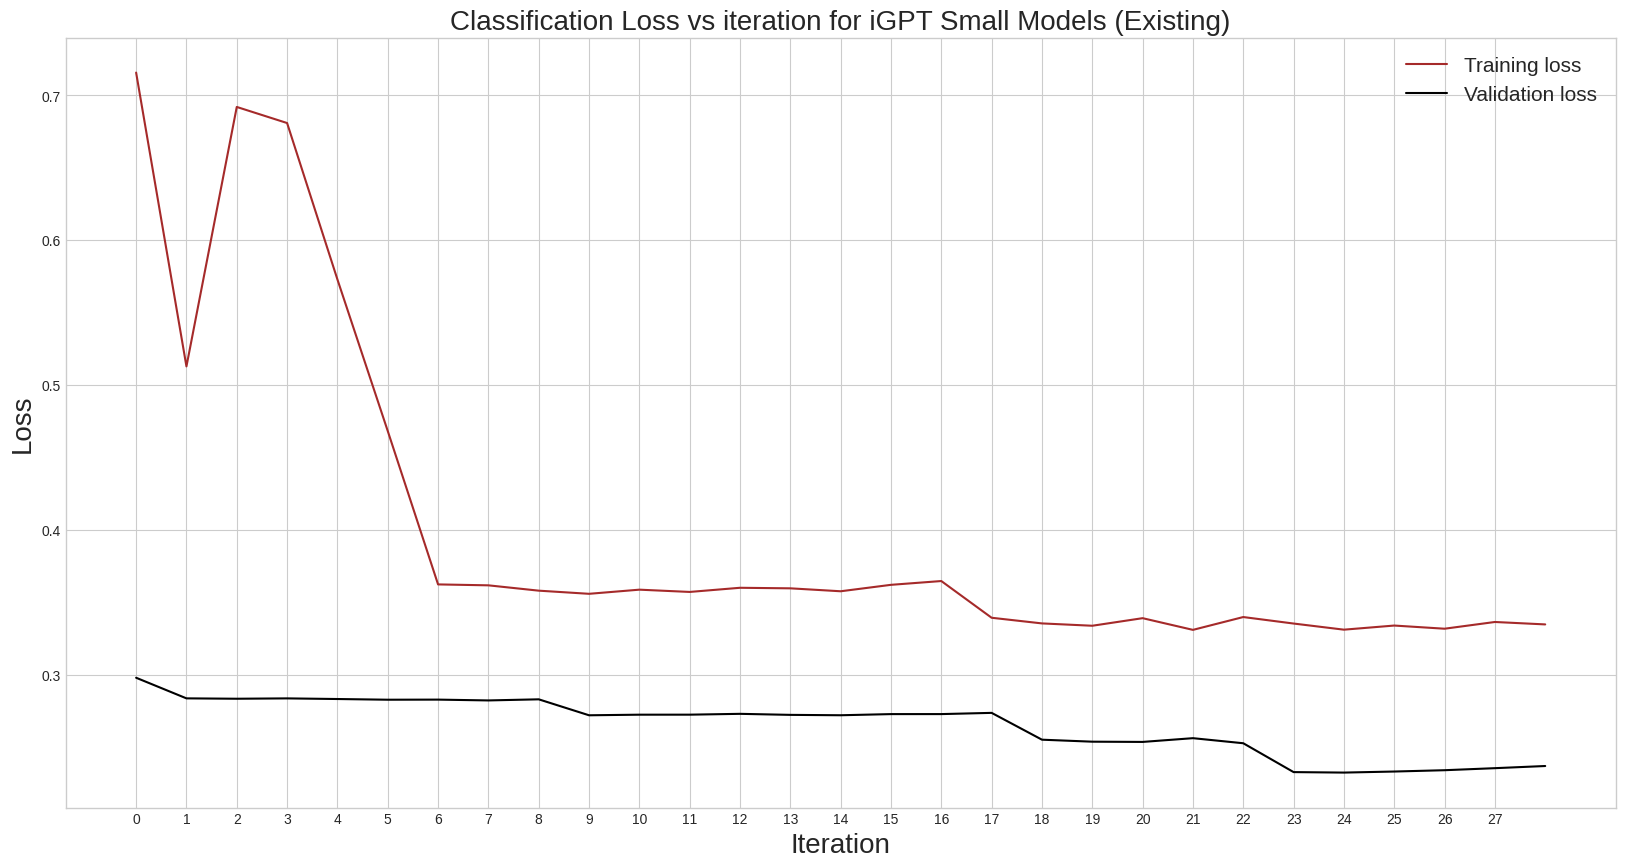

In [68]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_loss'],  label='Training loss',c='brown')
plt.plot(data['iterations'], data['val_loss']   , label='Validation loss',c='black')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification Loss vs iteration for iGPT Small Models (Existing)", fontsize= 20)

In [69]:
with open('/content/drive/MyDrive/iGPT_s_class_loss_proposed.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification Loss vs iteration for iGPT Small Models (Proposed)')

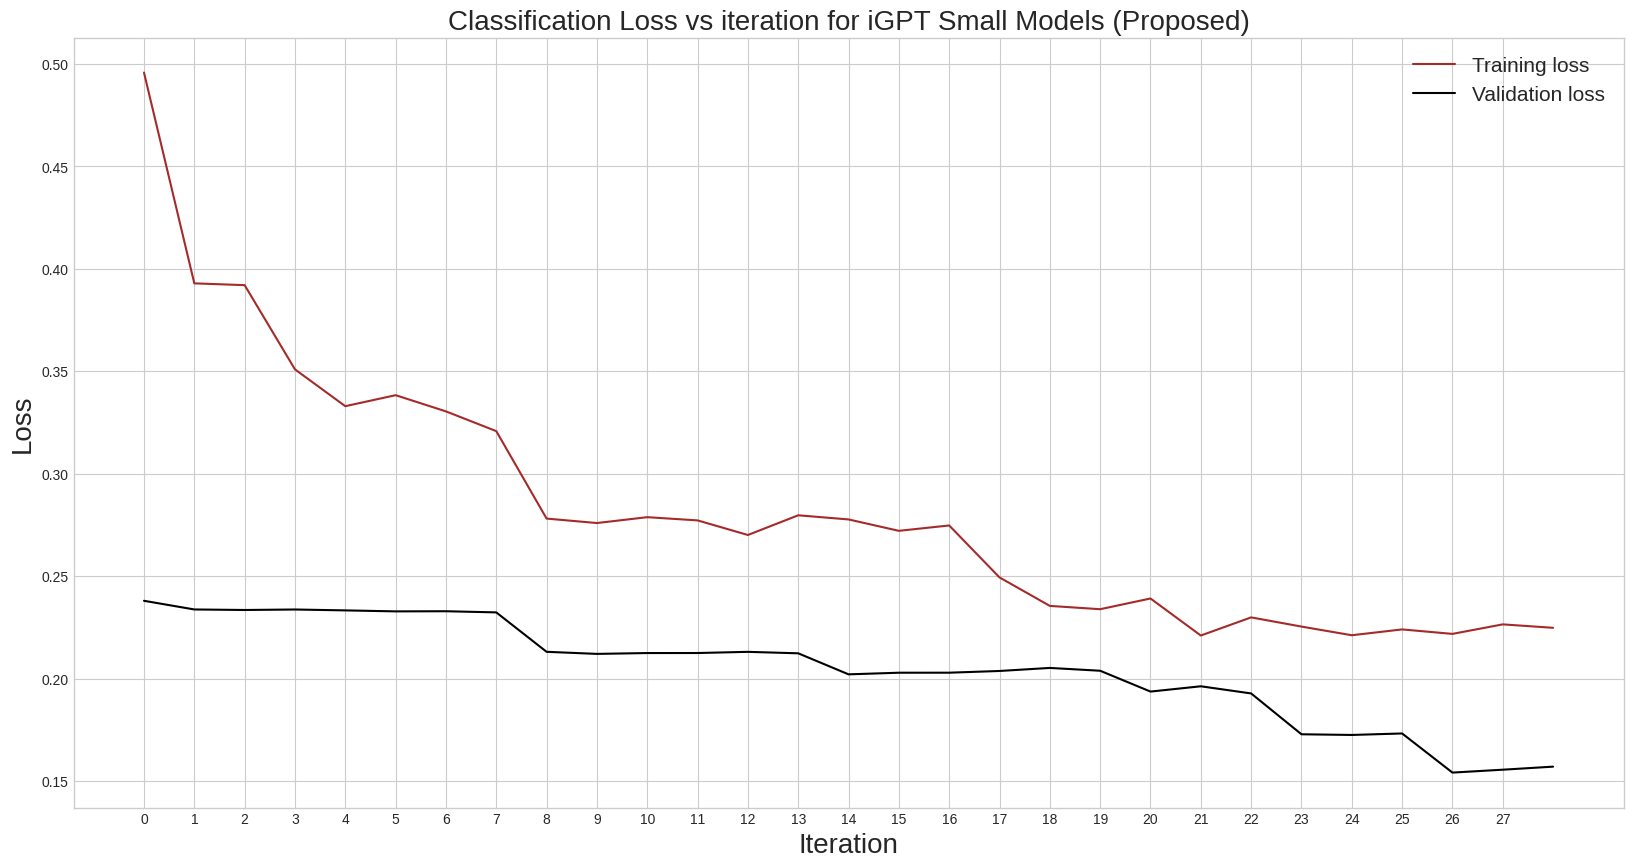

In [70]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_s_loss'],  label='Training loss',c='brown')
plt.plot(data['iterations'], data['val_s_loss']   , label='Validation loss',c='black')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification Loss vs iteration for iGPT Small Models (Proposed)", fontsize= 20)

In [71]:
with open('/content/drive/MyDrive/iGPT_s_class_acc.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification Accuracy vs iteration for iGPT Small Models (Existing)')

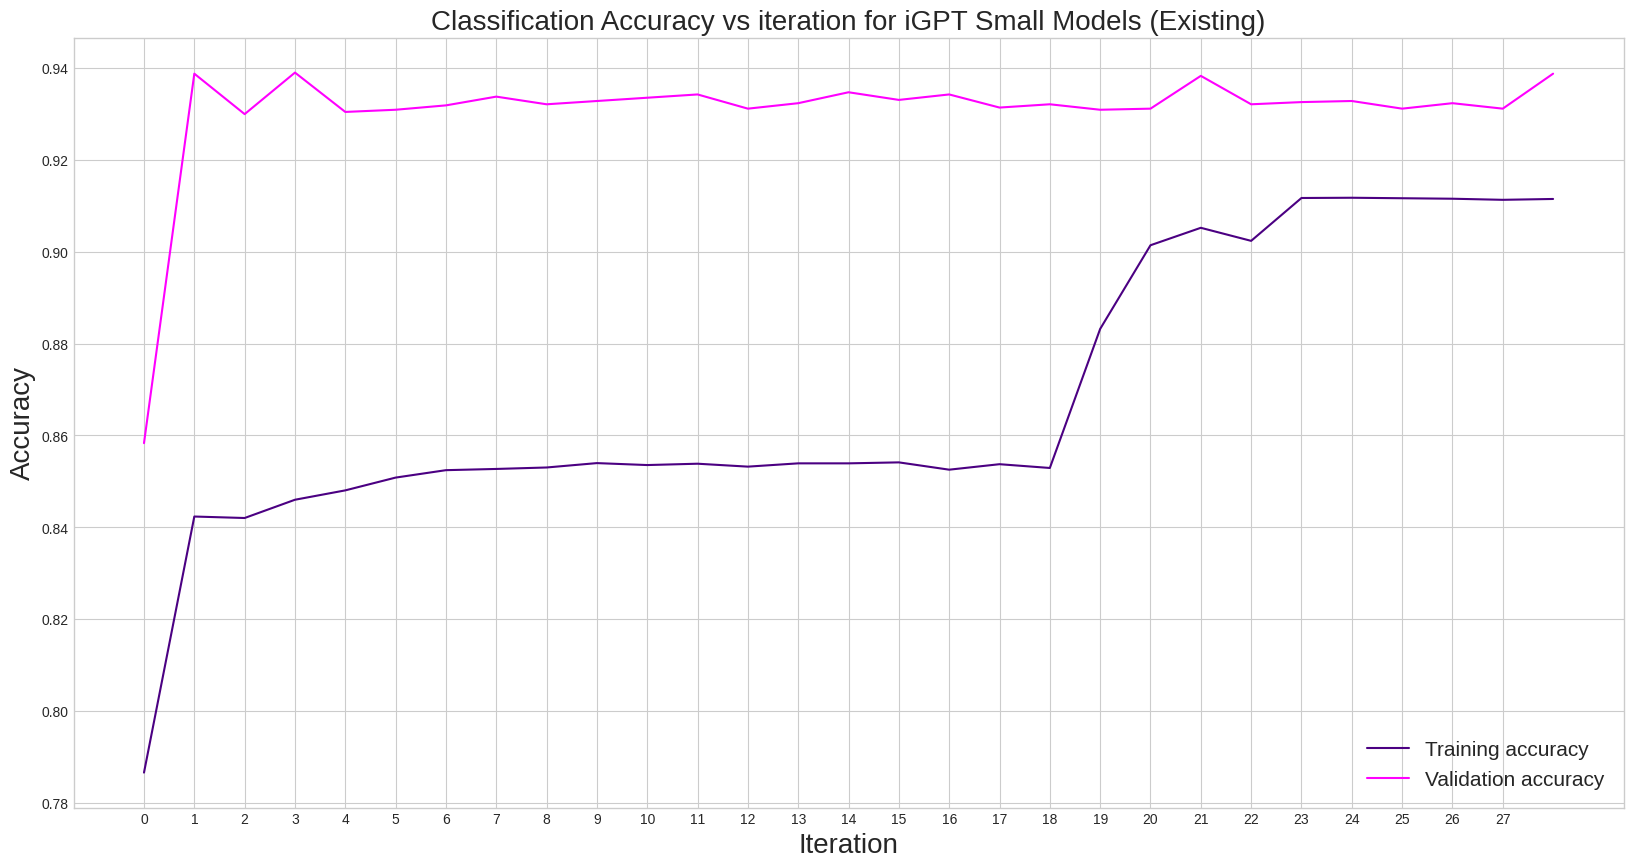

In [72]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_acc'],  label='Training accuracy',c='indigo')
plt.plot(data['iterations'], data['val_acc']   , label='Validation accuracy',c='magenta')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Accuracy", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification Accuracy vs iteration for iGPT Small Models (Existing)", fontsize= 20)


In [73]:
with open('/content/drive/MyDrive/iGPT_s_class_acc_proposed.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification Accuracy vs iteration for iGPT Small Models (Proposed)')

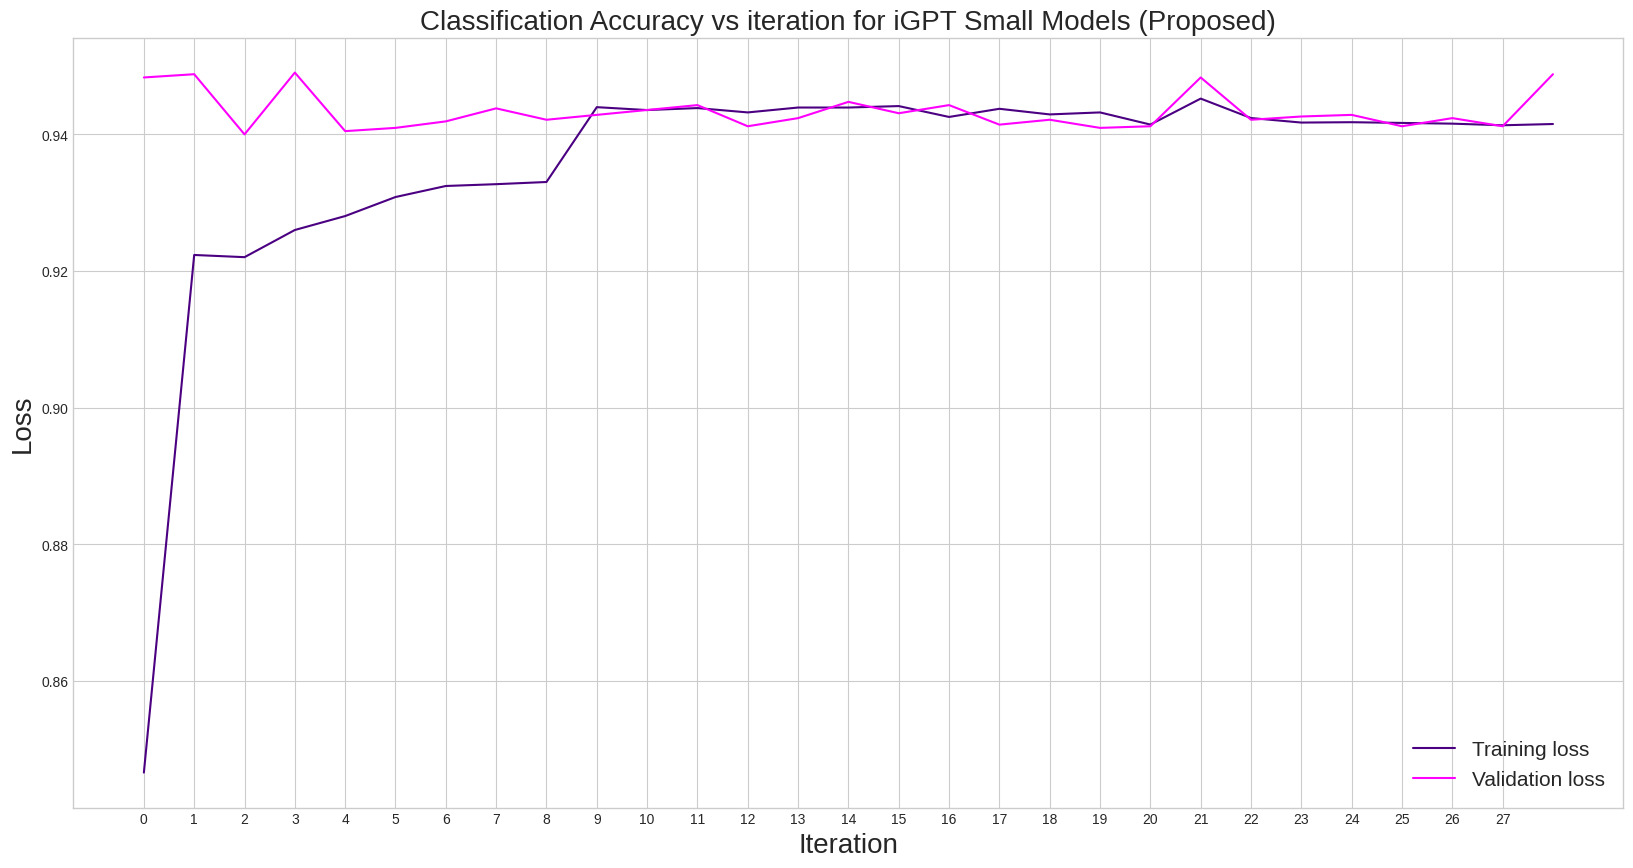

In [74]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_s_acc'],  label='Training loss',c='indigo')
plt.plot(data['iterations'], data['val_s_acc']   , label='Validation loss',c='magenta')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification Accuracy vs iteration for iGPT Small Models (Proposed)", fontsize= 20)

In [ ]:
with open('/content/drive/MyDrive/iGPT_all_class_loss.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification training loss vs iteration for all iGPT Models')

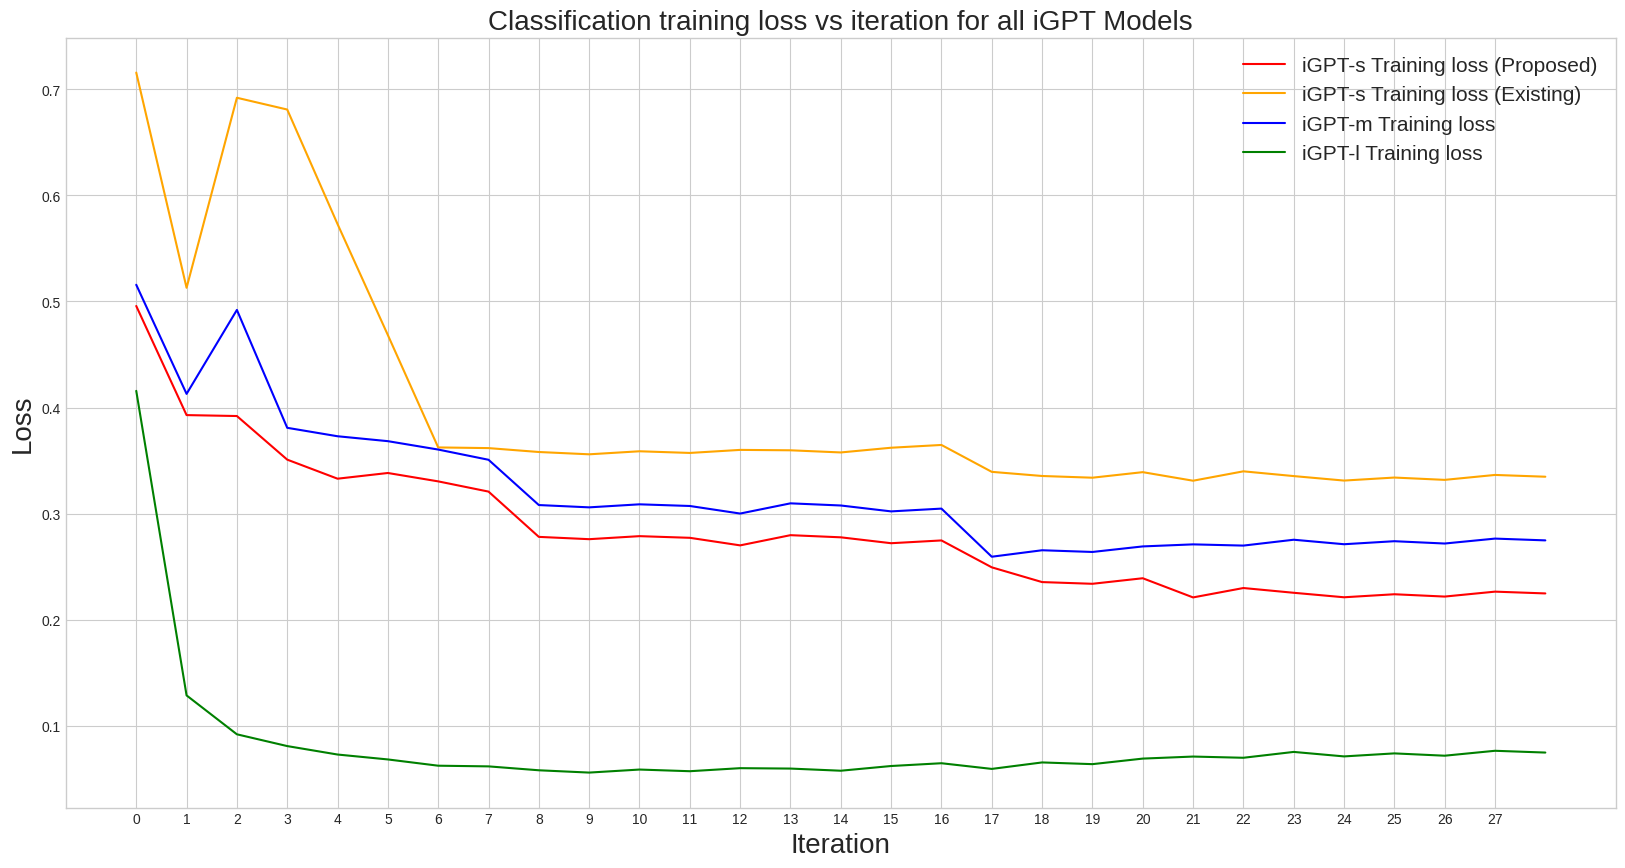

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_s_loss'],  label='iGPT-s Training loss (Proposed)',c='red')
plt.plot(data['iterations'], data['loss_small_original'],  label='iGPT-s Training loss (Existing)',c='orange')
plt.plot(data['iterations'], data['train_m_loss'],  label='iGPT-m Training loss',c='blue')
plt.plot(data['iterations'], data['train_l_loss'],  label='iGPT-l Training loss',c='green')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification training loss vs iteration for all iGPT Models", fontsize= 20)

Text(0.5, 1.0, 'Classification validation loss vs iteration for all iGPT Models')

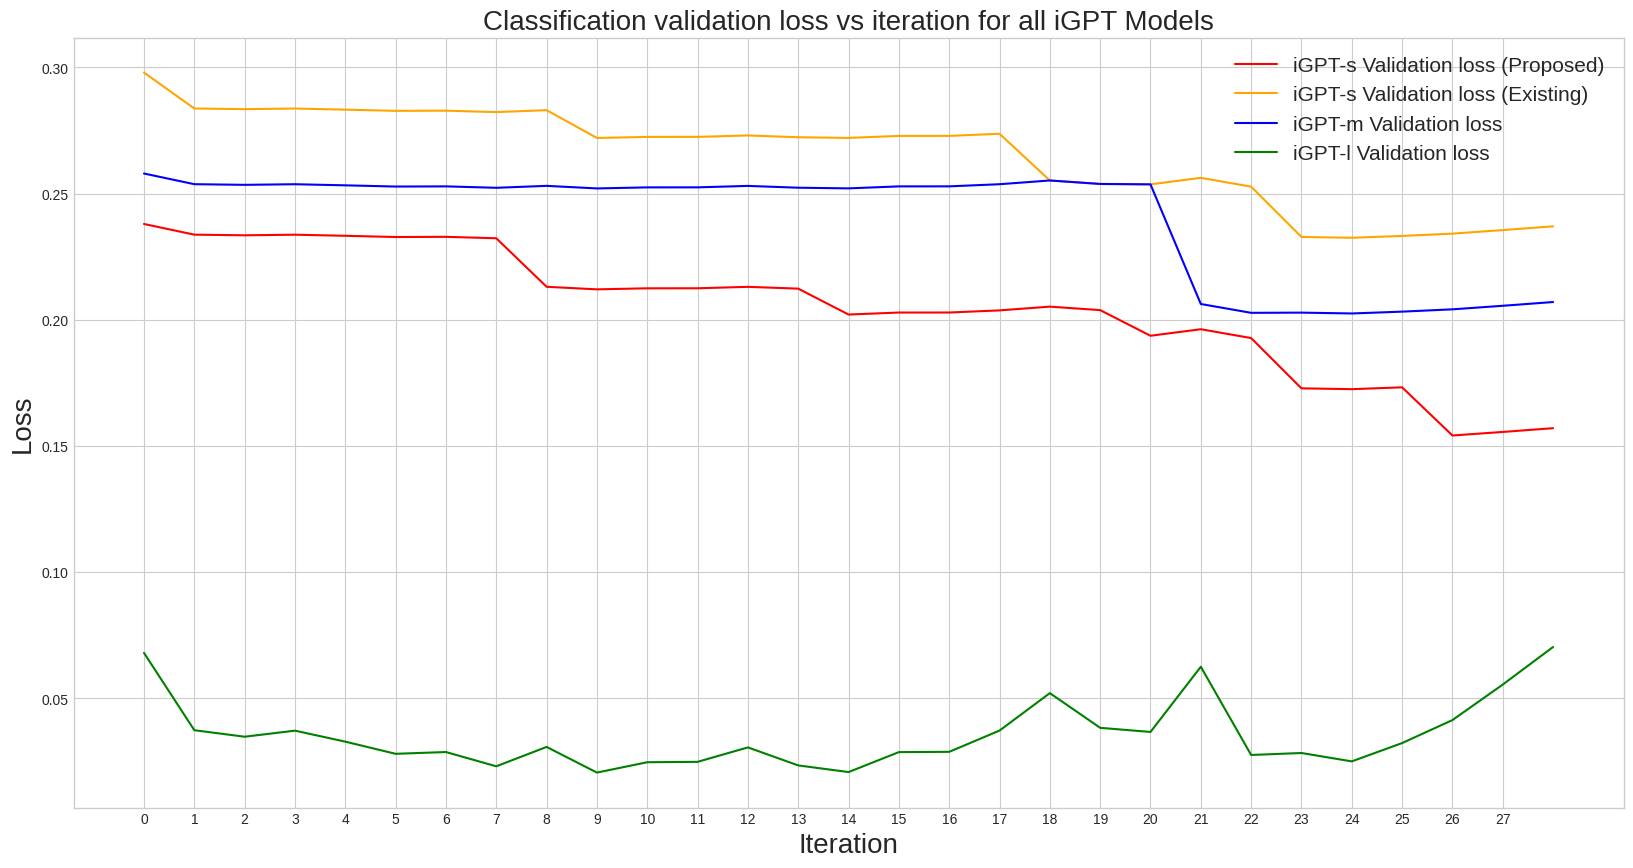

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['val_s_loss'],  label='iGPT-s Validation loss (Proposed)',c='red')
plt.plot(data['iterations'], data['val_s_loss_original'],  label='iGPT-s Validation loss (Existing)',c='orange')
plt.plot(data['iterations'], data['val_m_loss'],  label='iGPT-m Validation loss',c='blue')
plt.plot(data['iterations'], data['val_l_loss'],  label='iGPT-l Validation loss',c='green')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("Loss", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification validation loss vs iteration for all iGPT Models", fontsize= 20)

In [ ]:
with open('/content/drive/MyDrive/iGPT_all_class_acc.json', 'r') as f:
    data = json.load(f)

Text(0.5, 1.0, 'Classification training accuracy vs iteration for all iGPT Models')

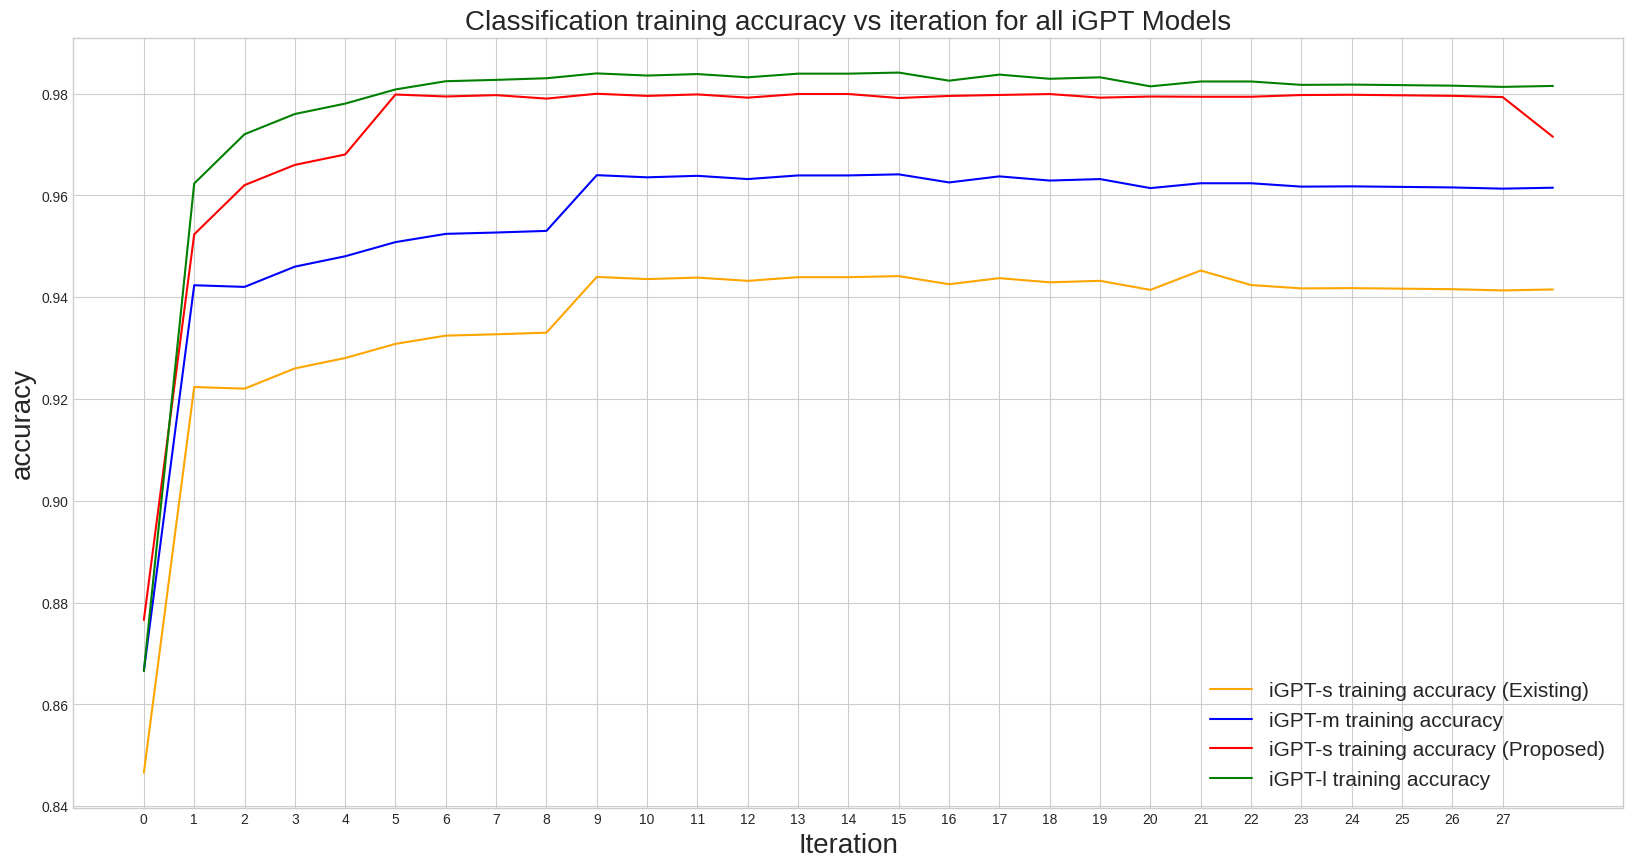

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['train_s_acc'],  label='iGPT-s training accuracy (Existing)',c='orange')
plt.plot(data['iterations'], data['train_m_acc'],  label='iGPT-m training accuracy',c='blue')
plt.plot(data['iterations'], data['train_base_acc'],  label='iGPT-s training accuracy (Proposed)',c='red')
plt.plot(data['iterations'], data['train_l_acc'],  label='iGPT-l training accuracy',c='green')

plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("accuracy", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification training accuracy vs iteration for all iGPT Models", fontsize= 20)

Text(0.5, 1.0, 'Classification validation accuracy vs iteration for all iGPT Models')

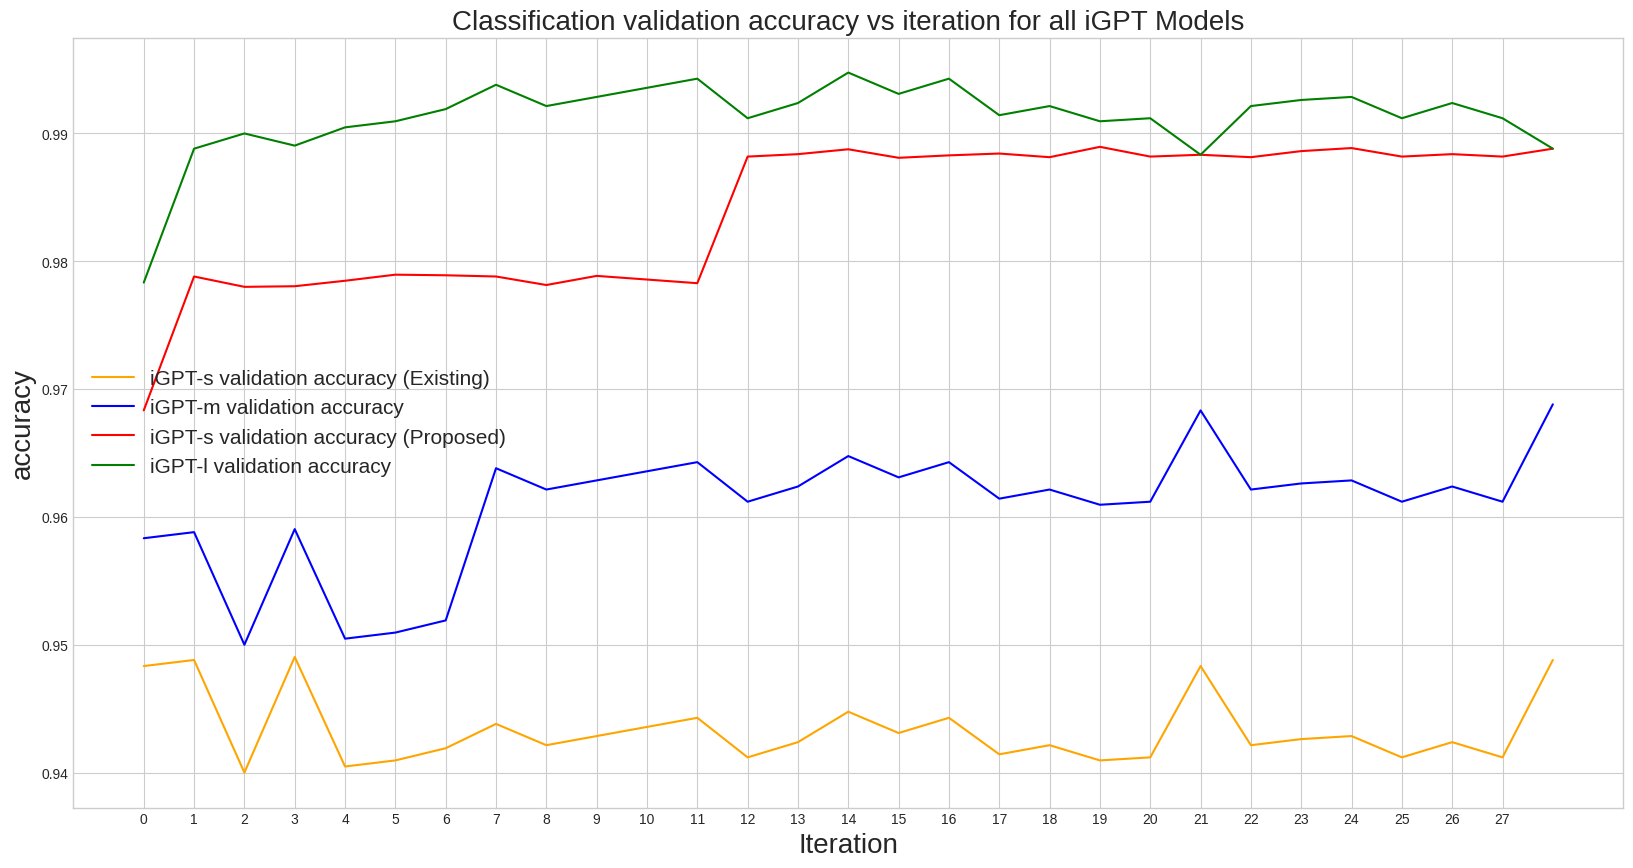

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['iterations'], data['val_s_acc'],  label='iGPT-s validation accuracy (Existing)',c='orange')
plt.plot(data['iterations'], data['val_m_acc'],  label='iGPT-m validation accuracy',c='blue')
plt.plot(data['iterations'], data['val_base_acc'],  label='iGPT-s validation accuracy (Proposed)',c='red')
plt.plot(data['iterations'], data['val_l_acc'],  label='iGPT-l validation accuracy',c='green')
plt.xlabel("Iteration", fontsize= 20)
plt.ylabel("accuracy", fontsize= 20)
 
# Set the tick locations
plt.xticks(arange(0, 28, 1))
 
# Display the plot
plt.legend(loc='best', fontsize=15)
plt.title("Classification validation accuracy vs iteration for all iGPT Models", fontsize= 20)

In [ ]:
# Look at confusion matrix 
from sklearn import datasets, svm, metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 


132/132 [==============================] - 0s 2ms/step


In [ ]:
print(
    f"Classification report for classifier iGPT:\n"
    f"{metrics.classification_report(Y_true, Y_pred_classes)}\n"
)

Classification report for classifier iGPT:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       411
           1       1.00      1.00      1.00       485
           2       0.99      1.00      1.00       403
           3       0.99      1.00      0.99       418
           4       0.98      1.00      0.99       461
           5       0.99      0.99      0.99       372
           6       0.99      0.99      0.99       413
           7       1.00      0.99      1.00       446
           8       0.99      0.99      0.99       382
           9       1.00      0.99      0.99       409

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200




Confusion matrix:
[[406   0   3   0   0   1   1   0   0   0]
 [  0 483   0   1   0   0   0   0   1   0]
 [  0   0 403   0   0   0   0   0   0   0]
 [  0   0   0 416   0   1   0   0   1   0]
 [  0   0   0   0 459   0   2   0   0   0]
 [  0   0   0   1   0 369   1   0   1   0]
 [  0   0   0   0   0   1 410   0   2   0]
 [  0   1   0   1   0   0   0 442   0   2]
 [  0   0   1   1   2   0   0   0 378   0]
 [  0   0   0   0   5   1   0   0   0 403]]


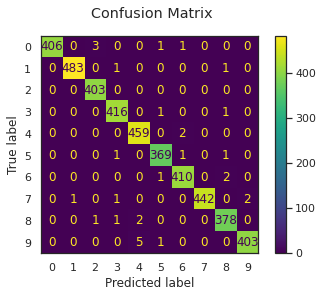

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_true, Y_pred_classes)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

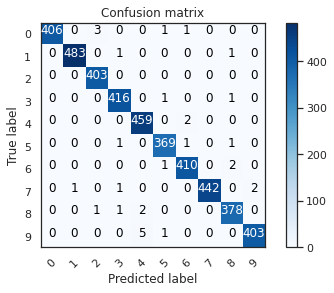

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that imageGPT model performs very well on all digits with few errors.

However, it seems that model has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Text(0, 0.5, 'y_pred')

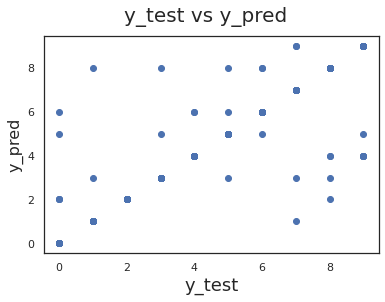

In [ ]:
fig = plt.figure()
plt.scatter(Y_true,Y_pred_classes)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16) 

**Kappa score:** It is a measure of inter-rater reliability. For logistic regression, the actual and predicted values of the target variable are the raters.

In [ ]:
# compute the kappa value
kappa = cohen_kappa_score(Y_true,Y_pred_classes)

# print the kappa value
print('kappa value:',kappa)

kappa value: 0.9917933414626736


**Interpretation:** As the kappa score for the full model (with cut-off probability 0.5) is 0.99, we can say that there is substantial agreement between the actual and predicted values.